In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy
from astropy.io import fits
import os
from datetime import datetime
from dateutil import parser
import matplotlib as mpl
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy import units as u
from astropy.time import Time
from scipy import stats
import matplotlib.dates as mdates
import cmath
%matplotlib inline

from scipy.signal import medfilt
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit
from chara_uvcalc import uv_calc
from binary_disk_point import binary_disk_point
from binary_disks_vector import binary_disks_vector

from PyAstronomy import pyasl
ks=pyasl.MarkleyKESolver()

plt.rcParams['xtick.labelsize']=10
plt.rcParams['ytick.labelsize']=10

eachindex = lambda lst: range(len(lst))

## Select the nights / directory

In [62]:
## ups and
date = '2023Oct_mircx_001.000'
tar_dir = '/Users/tgardner/data/2023Oct_UpsAnd_FANCY_SIMULATIONS/MIRCX/2023Oct/factor_001.000/medfilt/'
cal_dir = tar_dir ## generally we can make these the same, for self-calibration
#cal_dir = '/Users/tbg202/data/2023Apr_tauboo_mircx/'

In [63]:
## Test files to see spectral channels, e.g.

vlti_data = 'n'

print('n measure, n spectral channels = ')
for file in sorted(os.listdir(tar_dir)):
    if file.endswith('.oifits'):
        filename = os.path.join(tar_dir, file)
        print(filename)
        hdu = fits.open(filename)
        print(hdu['OI_T3'].data['T3PHI'].shape)
        print(hdu['OI_WAVELENGTH'].data['EFF_WAVE'])
        hdu.close()
    if vlti_data=='y':
        if file.endswith('fits'):
            filename = os.path.join(tar_dir, file)
            print(filename)
            hdu = fits.open(filename)
            print(hdu['OI_T3',10].data['T3PHI'].shape)
            print(hdu['OI_WAVELENGTH',10].data['EFF_WAVE'])
            hdu.close()

n measure, n spectral channels = 
/Users/tgardner/data/2023Oct_UpsAnd_FANCY_SIMULATIONS/MIRCX/2023Oct/factor_001.000/medfilt/FANCY_SIMULATION.UpsAnd.FACTOR_001.000.Omega51.inc156.MIRCX_L2.2023Oct03.ups_And.MIRCX_IDL.TG_Cal.AVG15m.MEDFILT.oifits
(94, 10)
[1.5103888e-06 1.5318342e-06 1.5533051e-06 1.5748016e-06 1.5963233e-06
 1.6178705e-06 1.6394432e-06 1.6610414e-06 1.6826649e-06 1.7043139e-06]
/Users/tgardner/data/2023Oct_UpsAnd_FANCY_SIMULATIONS/MIRCX/2023Oct/factor_001.000/medfilt/FANCY_SIMULATION.UpsAnd.FACTOR_001.000.Omega51.inc156.MIRCX_L2.2023Oct04.ups_And.MIRCX_IDL.TG_Cal.AVG15m.MEDFILT.oifits
(420, 10)
[1.5099721e-06 1.5314203e-06 1.5528949e-06 1.5743959e-06 1.5959237e-06
 1.6174778e-06 1.6390586e-06 1.6606658e-06 1.6822996e-06 1.7039598e-06]
/Users/tgardner/data/2023Oct_UpsAnd_FANCY_SIMULATIONS/MIRCX/2023Oct/factor_001.000/medfilt/FANCY_SIMULATION.UpsAnd.FACTOR_001.000.Omega51.inc156.MIRCX_L2.2023Oct05.ups_And.MIRCX_IDL.TG_Cal.AVG15m.MEDFILT.oifits
(428, 10)
[1.5102536e-06 1.5

In [64]:
#hdu = fits.open('/Users/tbg202/data/2019Sep_upsand/MIRCX_L2.2019Sep11.ups_And...TG_Cal.AVG5m_purged_median.oifits')
hdu.info()

Filename: /Users/tgardner/data/2023Oct_UpsAnd_FANCY_SIMULATIONS/MIRCX/2023Oct/factor_001.000/medfilt/FANCY_SIMULATION.UpsAnd.FACTOR_001.000.Omega51.inc156.MIRCX_L2.2023Oct07.ups_And.MIRCX_IDL.TG_Cal.AVG15m.MEDFILT.oifits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      13   ()      
  1  OI_ARRAY      1 BinTableHDU     28   6R x 5C   [16A, 16A, 1I, 1E, 3D]   
  2  OI_TARGET     1 BinTableHDU     56   1R x 17C   [1I, 16A, 1D, 1D, 1E, 1D, 1D, 1D, 8A, 8A, 1D, 1D, 1D, 1D, 1E, 1E, 16A]   
  3  OI_WAVELENGTH    1 BinTableHDU     18   10R x 2C   [1E, 1E]   
  4  OI_VIS        1 BinTableHDU     43   6649R x 12C   [1I, 1D, 1D, 1D, 10D, 10D, 10D, 10D, 1D, 1D, 2I, 10L]   
  5  OI_VIS2       1 BinTableHDU     39   357R x 10C   [1I, 1D, 1D, 1D, 10D, 10D, 1D, 1D, 2I, 10L]   
  6  OI_T3         1 BinTableHDU     51   450R x 14C   [1I, 1D, 1D, 1D, 10D, 10D, 10D, 10D, 1D, 1D, 1D, 1D, 3I, 10L]   


In [65]:
#hdu.close()

## Load in the data from all nights

In [66]:
## Use calibrators to measure drift with alt/az

t3phi = []
t3phierr = []
v2 = []
v2err = []
vphi = []
vphierr = []
hour_angle = []
hour_angle_v2 = []
az = []
alt = []
par_angle = []
tels = []
eff_wave = []
time_obs = []
time_obs_v2 = []
vistels = []
ucoords = []
vcoords = []

t3phi_cal = []
t3phierr_cal = []
v2_cal = []
v2err_cal = []
vphi_cal = []
vphierr_cal = []
hour_angle_cal = []
hour_angle_v2_cal = []
az_cal = []
alt_cal = []
par_angle_cal = []
tels_cal = []
eff_wave_cal = []
time_obs_cal = []
time_obs_v2_cal = []
vistels_cal = []
ucoords_cal = []
vcoords_cal = []

#new data:
beam_map = {1:'S1',2:'S2',3:'E1',4:'E2',5:'W1',6:'W2'}
#older data:
#beam_map = {0:'S1',1:'S2',2:'E1',3:'E2',4:'W1',5:'W2'}

## Load CALS first
print('----'*10)
print("Loading CALS (same as target for self calibration)")
print('----'*10)

for file in sorted(os.listdir(cal_dir)):
    if file.endswith('.oifits'):
        
        #if file.startswith('2021Oct17'):
        #    continue
        #if file.startswith('2021Oct18'):
        #    continue
        #if file.startswith('2021Oct20'):
        #    continue
    
        filename = os.path.join(cal_dir, file)
        print(filename)
        hdu = fits.open(filename)
    
        ra_deg = hdu['OI_TARGET'].data['RAEP0']
        dec_deg = hdu['OI_TARGET'].data['DECEP0']
        coord_icrs = SkyCoord(ra_deg*u.deg, dec_deg*u.deg, frame='icrs')
        chara = EarthLocation(lat=34.2259*u.deg, lon=-118.0571*u.deg, height=1734*u.m)
        #chara = EarthLocation(lat=-24.6667*u.deg, lon=-70.4167*u.deg, height=2635*u.m)
        #print("WARNING USING VLTI LOCATION")
    
        for table in hdu:
    
            ## t3phi data:
            wl_i=1
            if table.name=='OI_T3':
                for i in eachindex(table.data):
                    t3 = table.data[i]['T3PHI']
                    t3err = table.data[i]['T3PHIERR']
                    t3flag = np.where(table.data[i].field('FLAG')==True)
                    t3[t3flag] = np.nan
                    t3err[t3flag] = np.nan
                    t3phi_cal.append(t3)
                    t3phierr_cal.append(t3err)
                    #print(table.data[i]['STA_INDEX'])
                    #tels_cal.append([beam_map[a] for a in table.data[i]['STA_INDEX']])
                    tels_cal.append(table.data[i]['STA_INDEX'])
                    eff_wave_cal.append(hdu['OI_WAVELENGTH',wl_i].data['EFF_WAVE'])
                
                    time = table.data[i]['MJD']
                    time_obs_cal.append(time)
                    t = Time(time,format='mjd',location=chara)
                    sidereal = t.sidereal_time('apparent')
                    HA = (coord_icrs.ra.to(u.hourangle) - sidereal).hourangle
                    HA_rad = (coord_icrs.ra.to(u.hourangle) - sidereal).rad
                    aa = AltAz(location=chara, obstime=t)
                    alt_cal.append(coord_icrs.transform_to(aa).alt.deg[0])
                    az_cal.append(coord_icrs.transform_to(aa).az.deg[0])
                    pangle = np.arctan2(np.sin(HA_rad),np.tan(34.2259*np.pi/180)*np.cos(dec_deg[0]*np.pi/180)-np.sin(dec_deg[0]*np.pi/180)*np.cos(HA_rad))
                    #pangle = np.arcsin(np.sin(coord_icrs.transform_to(aa).az.deg[0]*np.pi/180)*np.cos(34.2259*np.pi/180)/np.cos(dec_deg[0]*np.pi/180))*180/np.pi
                    par_angle_cal.append(pangle[0]*180/np.pi)
                    hour_angle_cal.append(HA[0])
                
                wl_i+=1
                
            ## vis2 data:
            if table.name=='OI_VIS2':
                for i in eachindex(table.data):
                    vis = table.data[i]['VIS2DATA']
                    viserr = table.data[i]['VIS2ERR']
                    visflag = np.where(table.data[i].field('FLAG')==True)
                    vis[visflag] = np.nan
                    viserr[visflag] = np.nan
                    v2_cal.append(vis)
                    v2err_cal.append(viserr)
                    #print(table.data[i]['STA_INDEX'])
                    #vistels_cal.append([beam_map[a] for a in table.data[i]['STA_INDEX']])
                    vistels_cal.append(table.data[i]['STA_INDEX'])
                    ucoords_cal.append(table.data[i]['UCOORD'])
                    vcoords_cal.append(table.data[i]['VCOORD'])
                    
                    time = table.data[i]['MJD']
                    time_obs_v2_cal.append(time)
                    t = Time(time,format='mjd',location=chara)
                    sidereal = t.sidereal_time('apparent')
                    HA = (coord_icrs.ra.to(u.hourangle) - sidereal).hourangle
                    hour_angle_v2_cal.append(HA[0])
                    
            ## vphi data:
            if table.name=='OI_VIS':
                for i in eachindex(table.data):
                    vis = table.data[i]['VISPHI']
                    viserr = table.data[i]['VISPHIERR']
                    visflag = np.where(table.data[i].field('FLAG')==True)
                    vis[visflag] = np.nan
                    viserr[visflag] = np.nan
                    vphi_cal.append(vis)
                    vphierr_cal.append(viserr)

        hdu.close()
        
    if file.endswith('fits') and vlti_data=='y':
        
        vlti = EarthLocation(lat=-24.6667*u.deg, lon=-70.4167*u.deg, height=2635*u.m)
        
        filename = os.path.join(tar_dir, file)
        oifile = fits.open(filename,quiet=True)
        oi_t3 = oifile['OI_T3',10].data
        oi_vis2 = oifile['OI_VIS2',10].data
        oi_vis = oifile['OI_VIS',10].data
        oi_flux = oifile['OI_FLUX',10].data

        nwave = oifile['OI_WAVELENGTH',10].data.field('EFF_WAVE').shape[0]
        cut = int(nwave*0.05)

        eff_wave_cal.append(oifile['OI_WAVELENGTH',10].data.field('EFF_WAVE')[cut:-cut])
        target = oifile[0].header['OBJECT']
        print(filename, target)
        
        ra_deg = oifile['OI_TARGET'].data['RAEP0']
        dec_deg = oifile['OI_TARGET'].data['DECEP0']
        coord_icrs = SkyCoord(ra_deg*u.deg, dec_deg*u.deg, frame='icrs')
        
        index = oifile['OI_ARRAY'].data.field('STA_INDEX')
        names = oifile['OI_ARRAY'].data.field('STA_NAME')
        beam_map = dict(zip(index,names))

        for i in eachindex(oi_t3):
            t3 = oi_t3[i]['T3PHI']
            t3err = oi_t3[i]['T3PHIERR']
            idx = np.where(t3err==0.)
            t3[idx] = np.nan
            t3err[idx] = np.nan
            t3flag = np.where(oi_t3[i].field('FLAG')==True)
            t3[t3flag] = np.nan
            t3err[t3flag] = np.nan

            t3phi_cal.append(t3[cut:-cut])
            t3phierr_cal.append(t3err[cut:-cut])
            tels_cal.append([beam_map[a] for a in oi_t3[i].field('STA_INDEX')])
            
            time = oi_t3[i]['MJD']
            time_obs_cal.append(time)
            t = Time(time,format='mjd',location=vlti)
            sidereal = t.sidereal_time('apparent')
            HA = (coord_icrs.ra.to(u.hourangle) - sidereal).hourangle
            HA_rad = (coord_icrs.ra.to(u.hourangle) - sidereal).rad
            aa = AltAz(location=vlti, obstime=t)
            alt_cal.append(coord_icrs.transform_to(aa).alt.deg[0])
            az_cal.append(coord_icrs.transform_to(aa).az.deg[0])
            pangle = np.arctan2(np.sin(HA_rad),np.tan(-24.6667*np.pi/180)*np.cos(dec_deg[0]*np.pi/180)-np.sin(dec_deg[0]*np.pi/180)*np.cos(HA_rad))
            #pangle = np.arcsin(np.sin(coord_icrs.transform_to(aa).az.deg[0]*np.pi/180)*np.cos(34.2259*np.pi/180)/np.cos(dec_deg[0]*np.pi/180))*180/np.pi
            par_angle_cal.append(pangle[0]*180/np.pi)
            hour_angle_cal.append(HA[0])
                

        for i in eachindex(oi_vis2):
            vv2 = oi_vis2[i]['VIS2DATA']
            vv2err = oi_vis2[i]['VIS2ERR']
            idx = np.where(vv2err==0.)
            vv2[idx] = np.nan
            vv2err[idx] = np.nan
            vv2flag = np.where(oi_vis2[i].field('FLAG')==True)
            vv2[vv2flag] = np.nan
            vv2err[vv2flag] = np.nan

            v2_cal.append(vv2[cut:-cut])
            v2err_cal.append(vv2err[cut:-cut])
            vistels_cal.append([beam_map[a] for a in oi_vis2[i].field('STA_INDEX')])
            ucoords_cal.append(oi_vis2[i]['UCOORD'])
            vcoords_cal.append(oi_vis2[i]['VCOORD'])

        for i in eachindex(oi_vis):
            vvphi = oi_vis[i]['VISPHI']
            vvphierr = oi_vis[i]['VISPHIERR']
            idx = np.where(vphierr==0.)
            vvphi[idx] = np.nan
            vvphierr[idx] = np.nan
            vvphiflag = np.where(oi_vis[i].field('FLAG')==True)
            vvphi[vvphiflag] = np.nan
            vvphierr[vvphiflag] = np.nan

            vphi_cal.append(vvphi[cut:-cut])
            vphierr_cal.append(vvphierr[cut:-cut])

        oifile.close()
    
print('----'*10)
print('Load Target DATA')
print('----'*10)
    
for file in sorted(os.listdir(tar_dir)):
    if file.endswith('.oifits'):
    
        filename = os.path.join(tar_dir, file)
        print(filename)
        hdu = fits.open(filename)
    
        ra_deg = hdu['OI_TARGET'].data['RAEP0']
        dec_deg = hdu['OI_TARGET'].data['DECEP0']
        coord_icrs = SkyCoord(ra_deg*u.deg, dec_deg*u.deg, frame='icrs')
        chara = EarthLocation(lat=34.2259*u.deg, lon=-118.0571*u.deg, height=1734*u.m)
        #chara = EarthLocation(lat=-24.6667*u.deg, lon=-70.4167*u.deg, height=2635*u.m)
        #print("WARNING USING VLTI LOCATION")

        for table in hdu:
    
            ## t3phi data:
            wl_i=1
            if table.name=='OI_T3':
                for i in eachindex(table.data):
                    t3 = table.data[i]['T3PHI']
                    t3err = table.data[i]['T3PHIERR']
                    t3flag = np.where(table.data[i].field('FLAG')==True)
                    t3[t3flag] = np.nan
                    t3err[t3flag] = np.nan
                    t3phi.append(t3)
                    t3phierr.append(t3err)
                    #tels.append([beam_map[a] for a in table.data[i]['STA_INDEX']])
                    tels.append(table.data[i]['STA_INDEX'])
                    eff_wave.append(hdu['OI_WAVELENGTH',wl_i].data['EFF_WAVE'])
                
                    time = table.data[i]['MJD']
                    time_obs.append(time)
                    #print(time_obs)
                    t = Time(time,format='mjd',location=chara)
                    sidereal = t.sidereal_time('apparent')
                    HA = (coord_icrs.ra.to(u.hourangle) - sidereal).hourangle
                    HA_rad = (coord_icrs.ra.to(u.hourangle) - sidereal).rad
                    aa = AltAz(location=chara, obstime=t)
                    #print(coord_icrs.transform_to(aa).az)
                    alt.append(coord_icrs.transform_to(aa).alt.deg[0])
                    az.append(coord_icrs.transform_to(aa).az.deg[0])
                    pangle = np.arctan2(np.sin(HA_rad),np.tan(34.2259*np.pi/180)*np.cos(dec_deg[0]*np.pi/180)-np.sin(dec_deg[0]*np.pi/180)*np.cos(HA_rad))
                    #pangle = np.arcsin(np.sin(coord_icrs.transform_to(aa).az.deg[0]*np.pi/180)*np.cos(34.2259*np.pi/180)/np.cos(dec_deg[0]*np.pi/180))*180/np.pi
                    par_angle.append(pangle[0]*180/np.pi)
                    hour_angle.append(HA[0])
                wl_i+=1
                    
            ## vis2 data:
            if table.name=='OI_VIS2':
                for i in eachindex(table.data):
                    vis = table.data[i]['VIS2DATA']
                    viserr = table.data[i]['VIS2ERR']
                    visflag = np.where(table.data[i].field('FLAG')==True)
                    vis[visflag] = np.nan
                    viserr[visflag] = np.nan
                    v2.append(vis)
                    v2err.append(viserr)
                    #print(table.data[i]['STA_INDEX'])
                    #vistels.append([beam_map[a] for a in table.data[i]['STA_INDEX']])
                    vistels.append(table.data[i]['STA_INDEX'])
                    ucoords.append(table.data[i]['UCOORD'])
                    vcoords.append(table.data[i]['VCOORD'])
                    
                    time = table.data[i]['MJD']
                    time_obs_v2.append(time)
                    t = Time(time,format='mjd',location=chara)
                    sidereal = t.sidereal_time('apparent')
                    HA = (coord_icrs.ra.to(u.hourangle) - sidereal).hourangle
                    hour_angle_v2.append(HA[0])
                    
            ## vphi data:
            if table.name=='OI_VIS':
                for i in eachindex(table.data):
                    vis = table.data[i]['VISPHI']
                    viserr = table.data[i]['VISPHIERR']
                    visflag = np.where(table.data[i].field('FLAG')==True)
                    vis[visflag] = np.nan
                    viserr[visflag] = np.nan
                    vphi.append(vis)
                    vphierr.append(viserr)

        hdu.close()
        
    if file.endswith('fits') and vlti_data=='y':
        
        vlti = EarthLocation(lat=-24.6667*u.deg, lon=-70.4167*u.deg, height=2635*u.m)
        
        filename = os.path.join(tar_dir, file)
        oifile = fits.open(filename,quiet=True)
        oi_t3 = oifile['OI_T3',10].data
        oi_vis2 = oifile['OI_VIS2',10].data
        oi_vis = oifile['OI_VIS',10].data
        oi_flux = oifile['OI_FLUX',10].data

        nwave = oifile['OI_WAVELENGTH',10].data.field('EFF_WAVE').shape[0]
        cut = int(nwave*0.05)

        eff_wave.append(oifile['OI_WAVELENGTH',10].data.field('EFF_WAVE')[cut:-cut])
        target = oifile[0].header['OBJECT']
        print(filename, target)
        
        ra_deg = oifile['OI_TARGET'].data['RAEP0']
        dec_deg = oifile['OI_TARGET'].data['DECEP0']
        coord_icrs = SkyCoord(ra_deg*u.deg, dec_deg*u.deg, frame='icrs')
        
        index = oifile['OI_ARRAY'].data.field('STA_INDEX')
        names = oifile['OI_ARRAY'].data.field('STA_NAME')
        beam_map = dict(zip(index,names))

        for i in eachindex(oi_t3):
            t3 = oi_t3[i]['T3PHI']
            t3err = oi_t3[i]['T3PHIERR']
            idx = np.where(t3err==0.)
            t3[idx] = np.nan
            t3err[idx] = np.nan
            t3flag = np.where(oi_t3[i].field('FLAG')==True)
            t3[t3flag] = np.nan
            t3err[t3flag] = np.nan

            t3phi.append(t3[cut:-cut])
            t3phierr.append(t3err[cut:-cut])
            tels.append([beam_map[a] for a in oi_t3[i].field('STA_INDEX')])
            
            time = oi_t3[i]['MJD']
            time_obs.append(time)
            t = Time(time,format='mjd',location=vlti)
            sidereal = t.sidereal_time('apparent')
            HA = (coord_icrs.ra.to(u.hourangle) - sidereal).hourangle
            HA_rad = (coord_icrs.ra.to(u.hourangle) - sidereal).rad
            aa = AltAz(location=vlti, obstime=t)
            alt.append(coord_icrs.transform_to(aa).alt.deg[0])
            az.append(coord_icrs.transform_to(aa).az.deg[0])
            pangle = np.arctan2(np.sin(HA_rad),np.tan(-24.6667*np.pi/180)*np.cos(dec_deg[0]*np.pi/180)-np.sin(dec_deg[0]*np.pi/180)*np.cos(HA_rad))
            #pangle = np.arcsin(np.sin(coord_icrs.transform_to(aa).az.deg[0]*np.pi/180)*np.cos(34.2259*np.pi/180)/np.cos(dec_deg[0]*np.pi/180))*180/np.pi
            par_angle.append(pangle[0]*180/np.pi)
            hour_angle.append(HA[0])
                

        for i in eachindex(oi_vis2):
            vv2 = oi_vis2[i]['VIS2DATA']
            vv2err = oi_vis2[i]['VIS2ERR']
            idx = np.where(vv2err==0.)
            vv2[idx] = np.nan
            vv2err[idx] = np.nan
            vv2flag = np.where(oi_vis2[i].field('FLAG')==True)
            vv2[vv2flag] = np.nan
            vv2err[vv2flag] = np.nan

            v2.append(vv2[cut:-cut])
            v2err.append(vv2err[cut:-cut])
            vistels.append([beam_map[a] for a in oi_vis2[i].field('STA_INDEX')])
            ucoords.append(oi_vis2[i]['UCOORD'])
            vcoords.append(oi_vis2[i]['VCOORD'])

        for i in eachindex(oi_vis):
            vvphi = oi_vis[i]['VISPHI']
            vvphierr = oi_vis[i]['VISPHIERR']
            idx = np.where(vvphierr==0.)
            vvphi[idx] = np.nan
            vvphierr[idx] = np.nan
            vvphiflag = np.where(oi_vis[i].field('FLAG')==True)
            vvphi[vvphiflag] = np.nan
            vvphierr[vvphiflag] = np.nan

            vphi.append(vvphi[cut:-cut])
            vphierr.append(vvphierr[cut:-cut])

        oifile.close()
    
t3phi = np.array(t3phi)
t3phierr = np.array(t3phierr)
hour_angle = np.array(hour_angle)
hour_angle_v2 = np.array(hour_angle_v2)
az = np.array(az)
alt = np.array(alt)
tels = np.array(tels)
par_angle = np.array(par_angle)
eff_wave = np.array(eff_wave)
time_obs = np.array(time_obs)
time_obs_v2 = np.array(time_obs_v2)
v2 = np.array(v2)
v2err = np.array(v2err)
vphi = np.array(vphi)
vphierr = np.array(vphierr)
vistels = np.array(vistels)
ucoords = np.array(ucoords)
vcoords = np.array(vcoords)

t3phi_cal = np.array(t3phi_cal)
t3phierr_cal = np.array(t3phierr_cal)
hour_angle_cal = np.array(hour_angle_cal)
hour_angle_v2_cal = np.array(hour_angle_v2_cal)
az_cal = np.array(az_cal)
alt_cal = np.array(alt_cal)
tels_cal = np.array(tels_cal)
par_angle_cal = np.array(par_angle_cal)
eff_wave_cal = np.array(eff_wave_cal)
time_obs_cal = np.array(time_obs_cal)
time_obs_v2_cal = np.array(time_obs_v2_cal)
v2_cal = np.array(v2_cal)
v2err_cal = np.array(v2err_cal)
vphi_cal = np.array(vphi_cal)
vphierr_cal = np.array(vphierr_cal)
vistels_cal = np.array(vistels_cal)
ucoords_cal = np.array(ucoords_cal)
vcoords_cal = np.array(vcoords_cal)

----------------------------------------
Loading CALS (same as target for self calibration)
----------------------------------------
/Users/tgardner/data/2023Oct_UpsAnd_FANCY_SIMULATIONS/MIRCX/2023Oct/factor_001.000/medfilt/FANCY_SIMULATION.UpsAnd.FACTOR_001.000.Omega51.inc156.MIRCX_L2.2023Oct03.ups_And.MIRCX_IDL.TG_Cal.AVG15m.MEDFILT.oifits
/Users/tgardner/data/2023Oct_UpsAnd_FANCY_SIMULATIONS/MIRCX/2023Oct/factor_001.000/medfilt/FANCY_SIMULATION.UpsAnd.FACTOR_001.000.Omega51.inc156.MIRCX_L2.2023Oct04.ups_And.MIRCX_IDL.TG_Cal.AVG15m.MEDFILT.oifits
/Users/tgardner/data/2023Oct_UpsAnd_FANCY_SIMULATIONS/MIRCX/2023Oct/factor_001.000/medfilt/FANCY_SIMULATION.UpsAnd.FACTOR_001.000.Omega51.inc156.MIRCX_L2.2023Oct05.ups_And.MIRCX_IDL.TG_Cal.AVG15m.MEDFILT.oifits
/Users/tgardner/data/2023Oct_UpsAnd_FANCY_SIMULATIONS/MIRCX/2023Oct/factor_001.000/medfilt/FANCY_SIMULATION.UpsAnd.FACTOR_001.000.Omega51.inc156.MIRCX_L2.2023Oct06.ups_And.MIRCX_IDL.TG_Cal.AVG15m.MEDFILT.oifits
/Users/tgardner/data/20

In [67]:
#plt.plot(t3phi - t3phi_cal)
print(t3phi.shape, t3phi_cal.shape)
print(v2.shape, v2_cal.shape)
print(time_obs.shape, time_obs_cal.shape)
print(hour_angle.shape, az.shape, alt.shape, par_angle.shape)

(1907, 10) (1907, 10)
(1517, 10) (1517, 10)
(1907,) (1907,)
(1907,) (1907,) (1907,) (1907,)


In [68]:
## SUBTRACT OUT original data to leave only planet signal
#t3phi-=t3phi_cal
#t3phi_cal = t3phi.copy()

## Plot expected planet positions

In [69]:
def sep(a,w,i,e,P,T,bigw,t):
    
    A=a*(np.cos(bigw)*np.cos(w)-np.sin(bigw)*np.cos(i)*np.sin(w))
    B=a*(np.sin(bigw)*np.cos(w)+np.cos(bigw)*np.cos(i)*np.sin(w))
    F=a*(-np.cos(bigw)*np.sin(w)-np.sin(bigw)*np.cos(i)*np.cos(w))
    G=a*(-np.sin(bigw)*np.sin(w)+np.cos(bigw)*np.cos(i)*np.cos(w))

    
    #Calculate the mean anamoly for each t in dataset:
    #t=np.linspace(t,t+t2,n)
    print(t)
    
    M=[]
    for i in t:
        manom=2*np.pi/P*(i-T)
        M.append(manom)
    M=np.asarray(M)
    
    #eccentric anamoly calculated for each t (using kepler function):
    E=[]
    for j in M:
        eanom=ks.getE(j,e)
        #eanom=keplerE(j,e)
        E.append(eanom)  
    E=np.asarray(E)
    
    X=[]
    Y=[]
    for k in E:
        Xk=np.cos(k)-e
        Yk=np.sqrt(1-e**2)*np.sin(k)
        X.append(Xk)
        Y.append(Yk)
    
    X=np.asarray(X)
    Y=np.asarray(Y)
    dec=A*X+F*Y
    ra=B*X+G*Y
    
    pa=np.arctan2(ra,dec)*180/np.pi
    for idx, item in enumerate(pa):
        if item<0 and item>-180:
            pa[idx] = 360+item
            
    return ra,dec

[60220.43126706 60220.43109869 60220.43139238 ... 60224.52832095
 60224.52810485 60224.53456508]


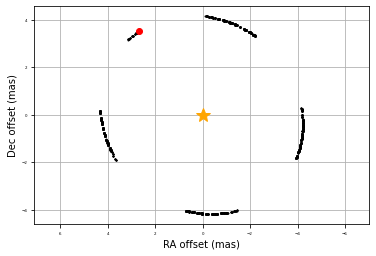

In [70]:
e   = 0.012 
w   = 224.106*np.pi/180
bigw = 51*np.pi/180 
inc = 25*np.pi/180 
a   = 4.43
P   = 4.617111
T   = 50033.553

#e   = 0.011
#w   = (113.4+180)*np.pi/180
#bigw = 100*np.pi/180 
#inc = 40*np.pi/180 
#a   = 3.13
#P   = 3.3124568
#T   = 56400.44

ra,dec = sep(a,w,inc,e,P,T,bigw,time_obs)
#ra2,dec2 = sep(a,w,75*np.pi/180,e,P,T,330*np.pi/180,time_obs)

fig = plt.figure()
ax = fig.add_subplot(111)
    
plt.plot(ra, dec, '.',markersize=2, color='black')
#plt.plot(ra2, dec2, 'r+',markersize=10)
plt.plot(ra[0],dec[0], 'o',color='red')
plt.plot(0,0,'*',markersize=15,color='orange')

plt.grid()
plt.xlabel('RA offset (mas)')
plt.ylabel('Dec offset (mas)')
#plt.xlim(-4,8)
#plt.ylim(-8,4)
plt.gca().invert_xaxis()
plt.axis('equal')
plt.savefig('%s/%s_planet_position.pdf'%(tar_dir,date))
plt.show()

## Now let's inspect all of the data

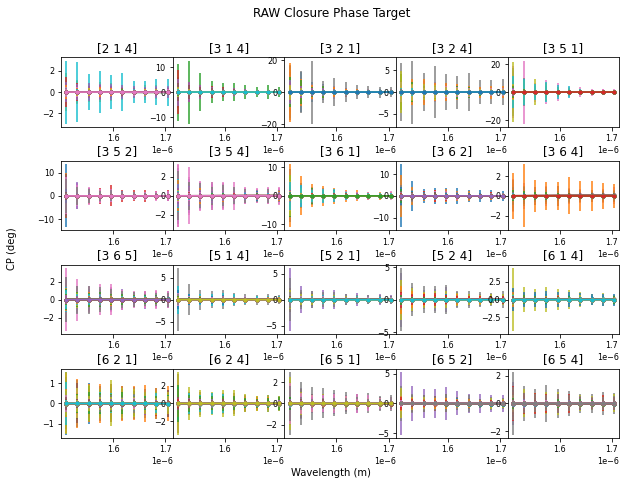

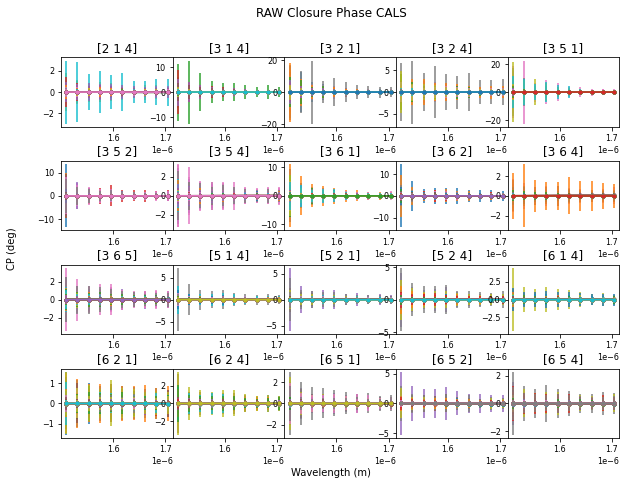

In [71]:
unique_tels = np.unique(tels,axis=0)
unique_tels_cal = np.unique(tels_cal,axis=0)

label_size = 8
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size

## Inspect data -- TARGET:

fig,axs = plt.subplots(4,5,figsize=(10,7),facecolor='w',edgecolor='k')
index = np.arange(len(unique_tels))

fig.subplots_adjust(hspace=0.5,wspace=.001)
axs=axs.ravel()

for ind in index:
    t3data=[]
    t3errdata=[]
    for t,terr,tri in zip(t3phi,t3phierr,tels):
        if str(tri)==str(unique_tels[int(ind)]):
            t3data.append(t)
            t3errdata.append(terr)
    t3data=np.array(t3data)
    t3errdata=np.array(t3errdata)

    for y,yerr in zip(t3data,t3errdata):
        x=eff_wave[0]
        axs[int(ind)].errorbar(x,y,yerr=yerr,fmt='.-')
    axs[int(ind)].set_title(str(unique_tels[int(ind)]))

fig.suptitle('RAW Closure Phase Target')
fig.text(0.5, 0.05, 'Wavelength (m)', ha='center')
fig.text(0.05, 0.5, 'CP (deg)', va='center', rotation='vertical')
plt.show()

## CALS:

fig,axs = plt.subplots(4,5,figsize=(10,7),facecolor='w',edgecolor='k')
index = np.arange(len(unique_tels_cal))

fig.subplots_adjust(hspace=0.5,wspace=.001)
axs=axs.ravel()

for ind in index:
    t3data=[]
    t3errdata=[]
    for t,terr,tri in zip(t3phi_cal,t3phierr_cal,tels_cal):
        if str(tri)==str(unique_tels_cal[int(ind)]):
            t3data.append(t)
            t3errdata.append(terr)
    t3data=np.array(t3data)
    t3errdata=np.array(t3errdata)

    for y,yerr in zip(t3data,t3errdata):
        x=eff_wave_cal[0]
        axs[int(ind)].errorbar(x,y,yerr=yerr,fmt='.-')
    axs[int(ind)].set_title(str(unique_tels_cal[int(ind)]))

fig.suptitle('RAW Closure Phase CALS')
fig.text(0.5, 0.05, 'Wavelength (m)', ha='center')
fig.text(0.05, 0.5, 'CP (deg)', va='center', rotation='vertical')
plt.show()

In [72]:
#unique_tels_vis = np.unique(vistels,axis=0)
#unique_tels_vis_cal = np.unique(vistels_cal,axis=0)

#label_size = 8
#mpl.rcParams['xtick.labelsize'] = label_size
#mpl.rcParams['ytick.labelsize'] = label_size

### Inspect data -- TARGET:

#fig,axs = plt.subplots(3,5,figsize=(10,7),facecolor='w',edgecolor='k')
#index = np.arange(len(unique_tels_vis))

#fig.subplots_adjust(hspace=0.5,wspace=.001)
#axs=axs.ravel()

#for ind in index:
#    vdata=[]
#    verrdata=[]
#    for t,terr,tri in zip(vphi,vphierr,vistels):
#        if str(tri)==str(unique_tels_vis[int(ind)]):
#            vdata.append(t)
#            verrdata.append(terr)
#    vdata=np.array(vdata)
#    verrdata=np.array(verrdata)

#    for y,yerr in zip(vdata,verrdata):
#        x=eff_wave[0]
#        axs[int(ind)].errorbar(x,y,yerr=yerr,fmt='.-')
#    axs[int(ind)].set_title(str(unique_tels_vis[int(ind)]))

#fig.suptitle('RAW VPHI Target')
#fig.text(0.5, 0.05, 'Wavelength (m)', ha='center')
#fig.text(0.05, 0.5, 'Visphi (deg)', va='center', rotation='vertical')
#plt.show()

### CALS:

#fig,axs = plt.subplots(3,5,figsize=(10,7),facecolor='w',edgecolor='k')
#index = np.arange(len(unique_tels_vis_cal))

#fig.subplots_adjust(hspace=0.5,wspace=.001)
#axs=axs.ravel()

#for ind in index:
#    vdata=[]
#    verrdata=[]
#    for t,terr,tri in zip(vphi_cal,vphierr_cal,vistels_cal):
#        if str(tri)==str(unique_tels_vis_cal[int(ind)]):
#            vdata.append(t)
#            verrdata.append(terr)
#    vdata=np.array(vdata)
#    verrdata=np.array(verrdata)

#    for y,yerr in zip(vdata,verrdata):
#        x=eff_wave_cal[0]
#        axs[int(ind)].errorbar(x,y,yerr=yerr,fmt='.-')
#    axs[int(ind)].set_title(str(unique_tels_vis_cal[int(ind)]))

#fig.suptitle('RAW VPHI CALS')
#fig.text(0.5, 0.05, 'Wavelength (m)', ha='center')
#fig.text(0.05, 0.5, 'Visphi (deg)', va='center', rotation='vertical')
#plt.show()

In [73]:
## do polynomial dispersion fit for each dphase measurement
#dispersion=[]
#for vis in vphi:
#    if np.count_nonzero(~np.isnan(vis))>0:
#        y=vis
#        x=eff_wave[0]
#        idx = np.isfinite(x) & np.isfinite(y)
#        z=np.polyfit(x[idx],y[idx],2)
#        p = np.poly1d(z)
#        dispersion.append(p(x))
#    else:
#        dispersion.append(vis)
#dispersion=np.array(dispersion)

#dispersion_cal=[]
#for vis in vphi_cal:
#    if np.count_nonzero(~np.isnan(vis))>0:
#        y=vis
#        x=eff_wave_cal[0]
#        idx = np.isfinite(x) & np.isfinite(y)
#        z=np.polyfit(x[idx],y[idx],2)
#        p = np.poly1d(z)
#        dispersion_cal.append(p(x))
#    else:
#        dispersion_cal.append(vis)
#dispersion_cal=np.array(dispersion_cal)

### subtract dispersion
#vphi-=dispersion
#vphi_cal-=dispersion_cal

In [74]:
#unique_tels_vis = np.unique(vistels,axis=0)
#unique_tels_vis_cal = np.unique(vistels_cal,axis=0)

#label_size = 8
#mpl.rcParams['xtick.labelsize'] = label_size
#mpl.rcParams['ytick.labelsize'] = label_size

### Inspect data -- TARGET:

#fig,axs = plt.subplots(3,5,figsize=(10,7),facecolor='w',edgecolor='k')
#index = np.arange(len(unique_tels_vis))

#fig.subplots_adjust(hspace=0.5,wspace=.001)
#axs=axs.ravel()

#for ind in index:
#    vdata=[]
#    verrdata=[]
#    for t,terr,tri in zip(vphi,vphierr,vistels):
#        if str(tri)==str(unique_tels_vis[int(ind)]):
#            vdata.append(t)
#            verrdata.append(terr)
#    vdata=np.array(vdata)
#    verrdata=np.array(verrdata)
#
#    for y,yerr in zip(vdata,verrdata):
#        x=eff_wave[0]
#        axs[int(ind)].errorbar(x,y,yerr=yerr,fmt='.-')
#    axs[int(ind)].set_title(str(unique_tels_vis[int(ind)]))

#fig.suptitle('RAW VPHI Target')
#fig.text(0.5, 0.05, 'Wavelength (m)', ha='center')
#fig.text(0.05, 0.5, 'Visphi (deg)', va='center', rotation='vertical')
#plt.show()

### CALS:

#fig,axs = plt.subplots(3,5,figsize=(10,7),facecolor='w',edgecolor='k')
#index = np.arange(len(unique_tels_vis_cal))

#fig.subplots_adjust(hspace=0.5,wspace=.001)
#axs=axs.ravel()

#for ind in index:
#    vdata=[]
#    verrdata=[]
#    for t,terr,tri in zip(vphi_cal,vphierr_cal,vistels_cal):
#        if str(tri)==str(unique_tels_vis_cal[int(ind)]):
#            vdata.append(t)
#            verrdata.append(terr)
#    vdata=np.array(vdata)
#    verrdata=np.array(verrdata)
#
#    for y,yerr in zip(vdata,verrdata):
#        x=eff_wave_cal[0]
#        axs[int(ind)].errorbar(x,y,yerr=yerr,fmt='.-')
#    axs[int(ind)].set_title(str(unique_tels_vis_cal[int(ind)]))
#
#fig.suptitle('RAW VPHI CALS')
#fig.text(0.5, 0.05, 'Wavelength (m)', ha='center')
#fig.text(0.05, 0.5, 'Visphi (deg)', va='center', rotation='vertical')
#plt.show()

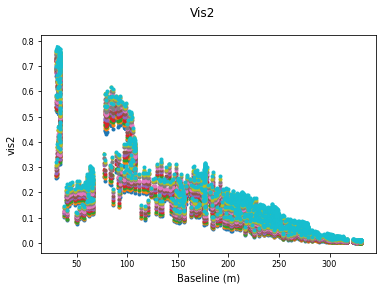

In [75]:
## plot vis2 data
unique_vistels = np.unique(vistels,axis=0)
unique_vistels_cal = np.unique(vistels_cal,axis=0)

fig,ax = plt.subplots()
fig.suptitle('Vis2')

nmeasure = np.arange(v2.shape[-1])
baseline = np.sqrt(ucoords**2+vcoords**2)
for i in nmeasure:
    ax.errorbar(baseline,v2[:,i],v2err[:,i],fmt='.')
ax.set_xlabel('Baseline (m)')
ax.set_ylabel('vis2')
plt.savefig("%s/%s_vis2.pdf"%(tar_dir,date))

## We can use the following cells to manually flag bad data. 
### Hopefully not necessary at this stage! Skip section

In [16]:
index_list = []

In [ ]:
## Run this cell if you want to manually get rid of some bad data 

print(t3phi.shape, tels.shape)

list_num = 0 ## keep this at 0
tel_num = 19 ## enter the triangle number you wish to inspect (0-19)

for data in t3phi:
    if str(tels[list_num])==str(unique_tels[tel_num]):
        if max(data)>4: ## uncomment max/min, enter value above/below which you want to purge
        #if min(data)<10:
            print(list_num)
            append = input("Append to index list? (y, [n])")
            if append=='y':
                index_list.append(list_num)
    list_num+=1
print(index_list)

In [ ]:
## Use this cell if you want to exclude a full telescope !!

tel1 = 'W2'
tel2 = 'E2'
tel3 = 'S1'
index=0
for data,telname in zip(t3phi,tels):
    if tel1 in telname and tel2 in telname:
        #print(telname)
        index_list.append(index)
    if tel1 in telname and tel3 in telname:
        #print(telname)
        index_list.append(index)
    index+=1

In [ ]:
## After flagging, use this cell to set bad data to nan
t3phi[index_list,:] = np.nan

In [ ]:
## Use this cell for the CALS (same list if self calibrating)
t3phi_cal[index_list,:] = np.nan

## Start from here if no manual purging of data necessary
### Here we will do some more inspection, and clean data if needed

In [76]:
## Another view of t3phi data
print("Stdev (deg) = ", np.nanstd(t3phi))
plt.plot(t3phi,'.')
plt.show()

Stdev (deg) =  0.009859496415791159


Standard deviation t3phi TAR =  0.000517669975396914
Standard deviation t3phi CAL =  0.000517669975396914


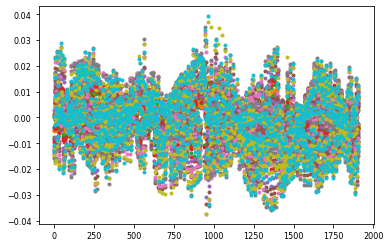

In [90]:
## Can run this cell (multiple times) to get rid of outliers, if desired !!
stdev_limit = 5
nloop = 0
while nloop<3:
    t3phi_filtered = medfilt(t3phi,(1,5))
    t3phi_resid = t3phi-t3phi_filtered
    std_t3phi = np.nanstd(t3phi_resid)
    idx_t3phi = np.where(abs(t3phi_resid)>(stdev_limit*std_t3phi))
    t3phi[idx_t3phi]=np.nan
    nloop+=1
print('Standard deviation t3phi TAR = ',std_t3phi)

nloop = 0
while nloop<3:
    t3phi_filtered = medfilt(t3phi_cal,(1,5))
    t3phi_resid = t3phi_cal-t3phi_filtered
    std_t3phi = np.nanstd(t3phi_resid)
    idx_t3phi = np.where(abs(t3phi_resid)>(stdev_limit*std_t3phi))
    t3phi_cal[idx_t3phi]=np.nan
    nloop+=1
print('Standard deviation t3phi CAL = ',std_t3phi)

plt.plot(t3phi,'.')
plt.show()

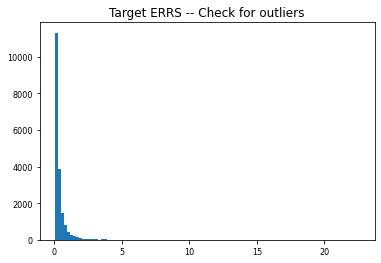

Avrage error =  0.43772091226516496
Stdev error =  0.8213983703230799
Minimum error =  0.05311344563961029
Maximum error =  22.58888053894043
N below 0.01 error =  0


In [91]:
## Check for bad error bar values:
plt.hist(np.ndarray.flatten(t3phierr),bins=100)
plt.title('Target ERRS -- Check for outliers')
#plt.xlim(0,1)
plt.show()

print("Avrage error = ",np.nanmean(t3phierr))
print("Stdev error = ", np.nanstd(t3phierr))
print("Minimum error = ",np.nanmin(t3phierr))
print("Maximum error = ",np.nanmax(t3phierr))

idx = np.where(t3phierr<0.01)
print("N below 0.01 error = ",len(t3phierr[idx]))

In [92]:
## Can use this cell to set an error floor on data (based on previous cell test) 
print('Min / Max Errors for TARGET')
print(np.nanmin(t3phierr),np.nanmax(t3phierr))

error_median = np.nanmedian(t3phierr)
error_floor = error_median/2
#error_floor = 0.01 ## set your own
print('Error floor = ',error_floor)

idx1 = np.where(t3phierr<error_floor)
##idx2 = np.where(t3phierr>t3phi_90)
#t3phierr[idx1]=error_floor

print("Min / Max new errors: ")
print(np.nanmin(t3phierr),np.nanmax(t3phierr))

Min / Max Errors for TARGET
0.05311344563961029 22.58888053894043
Error floor =  0.11384422704577446
Min / Max new errors: 
0.05311344563961029 22.58888053894043


In [93]:
## Same thing, but for CALS
print('Min / Max Errors for CAL')
print(np.nanmin(t3phierr_cal),np.nanmax(t3phierr_cal))

error_median = np.nanmedian(t3phierr_cal)
error_floor = error_median/2
#error_floor = 0.01 ## set your own
print('Error floor = ',error_floor)

idx1 = np.where(t3phierr_cal<error_floor)
##idx2 = np.where(t3phierr>t3phi_90)
#t3phierr[idx1]=error_floor

print("Min / Max new errors: ")
print(np.nanmin(t3phierr_cal),np.nanmax(t3phierr_cal))

Min / Max Errors for CAL
0.05311344563961029 22.58888053894043
Error floor =  0.11384422704577446
Min / Max new errors: 
0.05311344563961029 22.58888053894043


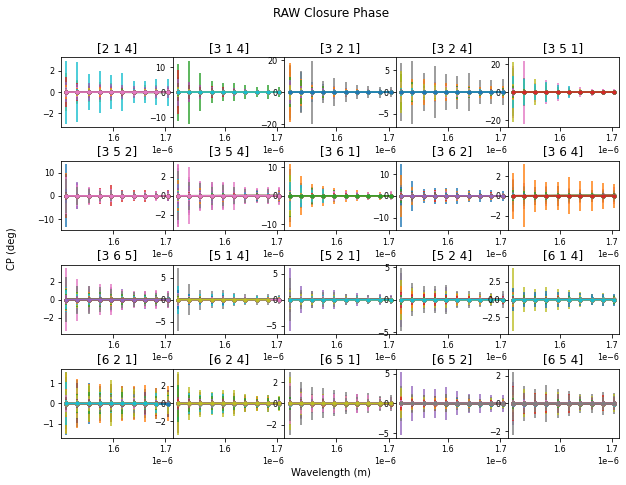

In [94]:
## Plot and save final RAW closure phase being used 
unique_tels = np.unique(tels,axis=0)

label_size = 8
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size

fig,axs = plt.subplots(4,5,figsize=(10,7),facecolor='w',edgecolor='k')
index = np.arange(len(unique_tels))

fig.subplots_adjust(hspace=0.5,wspace=.001)
axs=axs.ravel()

for ind in index:
    t3data=[]
    t3errdata=[]
    for t,terr,tri in zip(t3phi,t3phierr,tels):
        if str(tri)==str(unique_tels[int(ind)]):
            t3data.append(t)
            t3errdata.append(terr)
    t3data=np.array(t3data)
    t3errdata=np.array(t3errdata)

    for y,yerr in zip(t3data,t3errdata):
        x=eff_wave[0]
        axs[int(ind)].errorbar(x,y,yerr=yerr,fmt='.-')
    axs[int(ind)].set_title(str(unique_tels[int(ind)]))

fig.suptitle('RAW Closure Phase')
fig.text(0.5, 0.05, 'Wavelength (m)', ha='center')
fig.text(0.05, 0.5, 'CP (deg)', va='center', rotation='vertical')
plt.savefig('%s/%s_t3phi.pdf'%(tar_dir,date))
plt.show()

## Get data ready for fitting

In [95]:
## format hour angles
idx1 = np.where(hour_angle<-12)
idx2 = np.where(hour_angle>12)
hour_angle[idx1]+=24
hour_angle[idx2]-=24
hour_angle = -hour_angle

idx1 = np.where(hour_angle_cal<-12)
idx2 = np.where(hour_angle_cal>12)
hour_angle_cal[idx1]+=24
hour_angle_cal[idx2]-=24
hour_angle_cal = -hour_angle_cal

In [96]:
## format hour angles for v2
idx1 = np.where(hour_angle_v2<-12)
idx2 = np.where(hour_angle_v2>12)
hour_angle_v2[idx1]+=24
hour_angle_v2[idx2]-=24
hour_angle_v2 = -hour_angle_v2

idx1 = np.where(hour_angle_v2_cal<-12)
idx2 = np.where(hour_angle_v2_cal>12)
hour_angle_v2_cal[idx1]+=24
hour_angle_v2_cal[idx2]-=24
hour_angle_v2_cal = -hour_angle_v2_cal

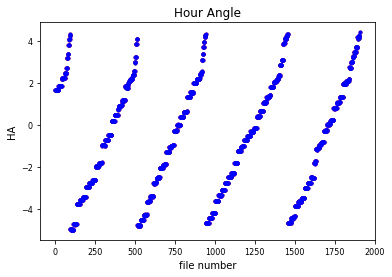

In [97]:
# show hour angle coverage
plt.plot(hour_angle,'.',color='r')
plt.plot(hour_angle_cal,'.',color='b')
plt.title('Hour Angle')
plt.ylabel('HA')
plt.xlabel('file number')
plt.show()

# show az coverage
plt.plot(((az*np.pi/180 + np.pi) % (2 * np.pi) - np.pi )*180/np.pi, '.',color='lightgrey')
plt.plot(((az_cal*np.pi/180 + np.pi) % (2 * np.pi) - np.pi )*180/np.pi, '.',color='lightgrey')
plt.plot(az,'.',color='r')
plt.plot(az_cal,'.',color='b')
plt.title('Azimuth')
plt.ylabel('AZ')
plt.xlabel('file number')
plt.show()

# show alt coverage
plt.plot(alt,'.',color='r')
plt.plot(alt_cal,'.',color='b')
plt.title('Altitude')
plt.ylabel('Alt')
plt.xlabel('file number')
plt.show()

## show parallactic angle
plt.plot(par_angle,'.',color='r')
plt.plot(par_angle_cal,'.',color='b')
plt.title('Parallactic Angle')
plt.ylabel('PA')
plt.xlabel('file number')
plt.show()

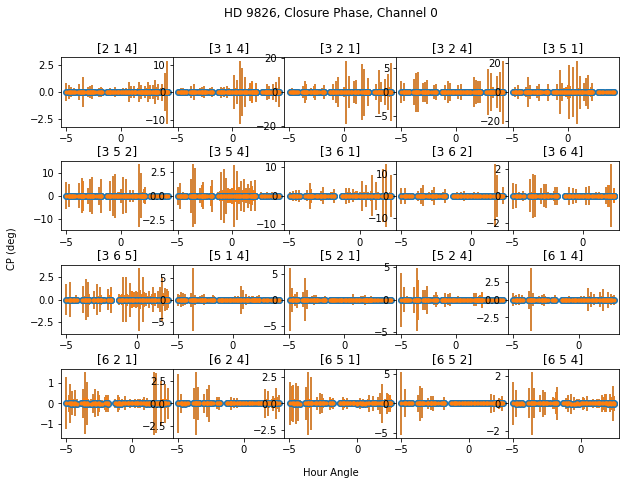

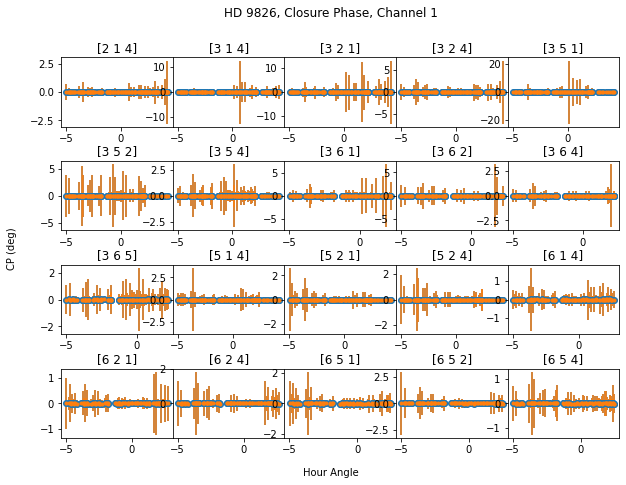

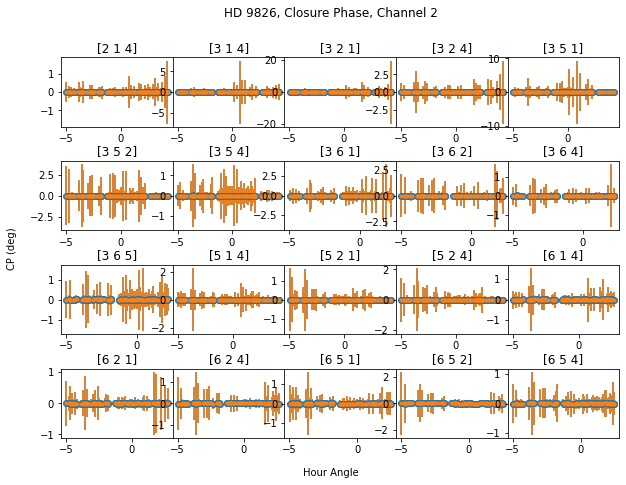

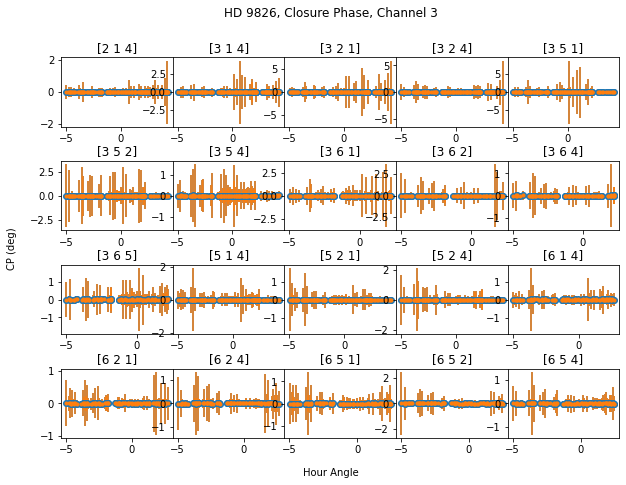

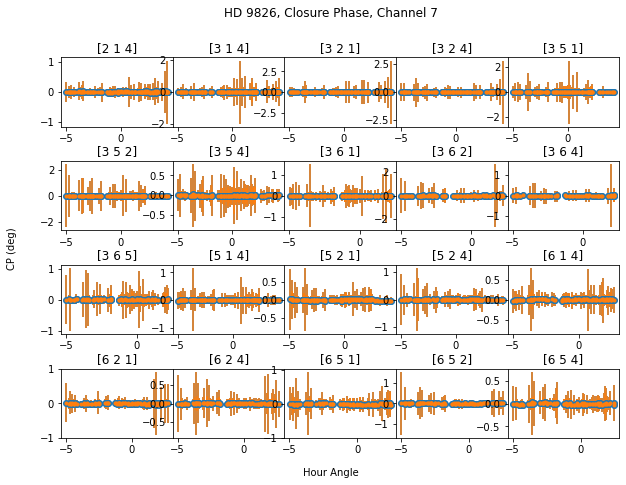

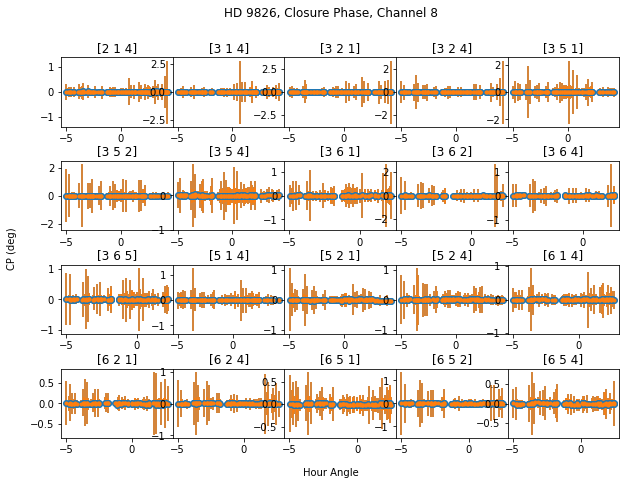

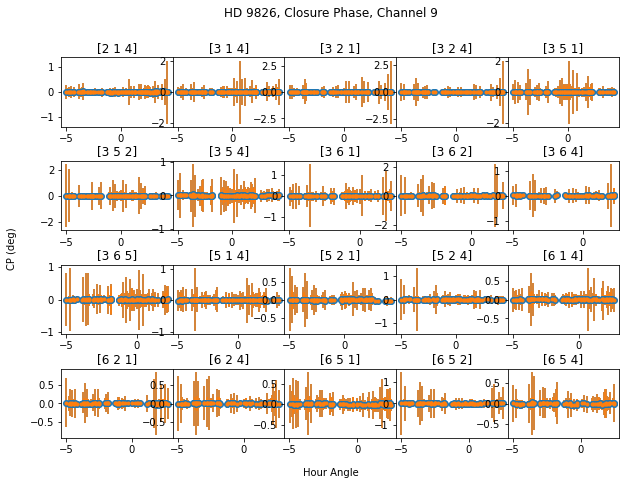

In [98]:
###################
#### Plot vs HA
###################

channel = np.arange(t3phi_cal.shape[-1])
#channel = [100,500,1000,1500]

label_size = 10
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size

for chan in channel:
    
    fig,axs = plt.subplots(4,5,figsize=(10,7),facecolor='w',edgecolor='k')
    index = np.arange(len(unique_tels_cal))
        
    fig.subplots_adjust(hspace=0.5,wspace=.001)
    axs=axs.ravel()
        
    for ind in index:
        
        ## CAL
        t3data=[]
        t3errdata=[]
        hdata=[]
        for t,terr,tri,tt in zip(t3phi_cal,t3phierr_cal,tels_cal,hour_angle_cal):
            if str(tri)==str(unique_tels_cal[int(ind)]):
                t3data.append(t)
                t3errdata.append(terr)
                hdata.append(tt)
        t3data=np.array(t3data)
        t3errdata=np.array(t3errdata)
        hdata=np.array(hdata)

        x=hdata
        y=t3data[:,chan]
        yerr=t3errdata[:,chan]
        axs[int(ind)].errorbar(x,y,yerr=yerr,fmt='o')
        axs[int(ind)].set_title(str(unique_tels_cal[int(ind)]))
        
        ## TAR
        t3data=[]
        t3errdata=[]
        hdata=[]
        for t,terr,tri,tt in zip(t3phi,t3phierr,tels,hour_angle):
            if str(tri)==str(unique_tels[int(ind)]):
                t3data.append(t)
                t3errdata.append(terr)
                hdata.append(tt)
        t3data=np.array(t3data)
        t3errdata=np.array(t3errdata)
        hdata=np.array(hdata)

        x=hdata
        y=t3data[:,chan]
        yerr=t3errdata[:,chan]
        axs[int(ind)].errorbar(x,y,yerr=yerr,fmt='.')
        #axs[int(ind)].set_ylim(-3,3)

    fig.suptitle('HD 9826, Closure Phase, Channel %s'%chan)
    fig.text(0.5, 0.05, 'Hour Angle', ha='center')
    fig.text(0.05, 0.5, 'CP (deg)', va='center', rotation='vertical')
    plt.savefig('%s/%s_ha_t3phi_%s.pdf'%(tar_dir,date,chan))
    plt.show()

In [ ]:
 ###################
#### Plot vs PA
###################

channel = np.arange(t3phi_cal.shape[-1])
#channel = [100,500,1000,1500]

label_size = 10
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size

for chan in channel:
    
    fig,axs = plt.subplots(4,5,figsize=(10,7),facecolor='w',edgecolor='k')
    index = np.arange(len(unique_tels_cal))
        
    fig.subplots_adjust(hspace=0.5,wspace=.001)
    axs=axs.ravel()
        
    for ind in index:
        
        ## CAL
        t3data=[]
        t3errdata=[]
        hdata=[]
        for t,terr,tri,tt in zip(t3phi_cal,t3phierr_cal,tels_cal,par_angle_cal):
            if str(tri)==str(unique_tels_cal[int(ind)]):
                t3data.append(t)
                t3errdata.append(terr)
                hdata.append(tt)
        t3data=np.array(t3data)
        t3errdata=np.array(t3errdata)
        hdata=np.array(hdata)

        x=hdata
        y=t3data[:,chan]
        yerr=t3errdata[:,chan]
        axs[int(ind)].errorbar(x,y,yerr=yerr,fmt='o')
        axs[int(ind)].set_title(str(unique_tels_cal[int(ind)]))
        
        ## TAR
        t3data=[]
        t3errdata=[]
        hdata=[]
        for t,terr,tri,tt in zip(t3phi,t3phierr,tels,par_angle):
            if str(tri)==str(unique_tels[int(ind)]):
                t3data.append(t)
                t3errdata.append(terr)
                hdata.append(tt)
        t3data=np.array(t3data)
        t3errdata=np.array(t3errdata)
        hdata=np.array(hdata)

        x=hdata
        y=t3data[:,chan]
        yerr=t3errdata[:,chan]
        axs[int(ind)].errorbar(x,y,yerr=yerr,fmt='.')
        #axs[int(ind)].set_ylim(-3,3)

    fig.suptitle('HD 9826, Closure Phase, Channel %s'%chan)
    fig.text(0.5, 0.05, 'Par Angle', ha='center')
    fig.text(0.05, 0.5, 'CP (deg)', va='center', rotation='vertical')
    plt.savefig('%s/%s_par_angle_t3phi_%s.pdf'%(tar_dir,date,chan))

In [ ]:
 ###################
#### Plot vs TIME
###################

channel = np.arange(t3phi_cal.shape[-1])
#channel = [100,500,1000,1500]

label_size = 10
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size

for chan in channel:
    
    fig,axs = plt.subplots(4,5,figsize=(10,7),facecolor='w',edgecolor='k')
    index = np.arange(len(unique_tels_cal))
        
    fig.subplots_adjust(hspace=0.5,wspace=.001)
    axs=axs.ravel()
        
    for ind in index:
        
        ## CAL
        t3data=[]
        t3errdata=[]
        hdata=[]
        for t,terr,tri,tt in zip(t3phi_cal,t3phierr_cal,tels_cal,time_obs_cal):
            if str(tri)==str(unique_tels_cal[int(ind)]):
                t3data.append(t)
                t3errdata.append(terr)
                hdata.append(tt)
        t3data=np.array(t3data)
        t3errdata=np.array(t3errdata)
        hdata=np.array(hdata)

        x=hdata
        y=t3data[:,chan]
        yerr=t3errdata[:,chan]
        axs[int(ind)].errorbar(x,y,yerr=yerr,fmt='o')
        axs[int(ind)].set_title(str(unique_tels_cal[int(ind)]))
        
        ## TAR
        t3data=[]
        t3errdata=[]
        hdata=[]
        for t,terr,tri,tt in zip(t3phi,t3phierr,tels,time_obs):
            if str(tri)==str(unique_tels[int(ind)]):
                t3data.append(t)
                t3errdata.append(terr)
                hdata.append(tt)
        t3data=np.array(t3data)
        t3errdata=np.array(t3errdata)
        hdata=np.array(hdata)

        x=hdata
        y=t3data[:,chan]
        yerr=t3errdata[:,chan]
        axs[int(ind)].errorbar(x,y,yerr=yerr,fmt='.')
        #axs[int(ind)].set_ylim(-10,10)

    fig.suptitle('HD 9826, Closure Phase, Channel %s'%chan)
    fig.text(0.5, 0.05, 'Time', ha='center')
    fig.text(0.05, 0.5, 'CP (deg)', va='center', rotation='vertical')
    plt.savefig('%s/%s_time_t3phi_%s.pdf'%(tar_dir,date,chan))

In [31]:
###################
#### Plot vs HA -- Vis2
###################

#channel = np.arange(v2_cal.shape[-1])

#label_size = 10
#mpl.rcParams['xtick.labelsize'] = label_size
#mpl.rcParams['ytick.labelsize'] = label_size

#for chan in channel:
    
#    fig,axs = plt.subplots(3,5,figsize=(10,7),facecolor='w',edgecolor='k')
#    index = np.arange(len(unique_vistels_cal))
        
#    fig.subplots_adjust(hspace=0.5,wspace=.001)
#    axs=axs.ravel()
        
#    for ind in index:
        
#        ## CAL
#        v2data=[]
#        v2errdata=[]
#        hdata=[]
#        for t,terr,tri,tt in zip(v2_cal,v2err_cal,vistels_cal,hour_angle_v2_cal):
#            if str(tri)==str(unique_vistels_cal[int(ind)]):
#                v2data.append(t)
#                v2errdata.append(terr)
#                hdata.append(tt)
#        v2data=np.array(v2data)
#        v2errdata=np.array(v2errdata)
#        hdata=np.array(hdata)

#        x=hdata
#        y=v2data[:,chan]
#        yerr=v2errdata[:,chan]
#        axs[int(ind)].errorbar(x,y,yerr=yerr,fmt='o')
#        axs[int(ind)].set_title(str(unique_vistels_cal[int(ind)]))
        
#        ### TAR
#        v2data=[]
#        v2errdata=[]
#        hdata=[]
#        for t,terr,tri,tt in zip(v2,v2err,vistels,hour_angle_v2):
#            if str(tri)==str(unique_vistels[int(ind)]):
#                v2data.append(t)
#                v2errdata.append(terr)
#                hdata.append(tt)
#        v2data=np.array(v2data)
#        v2errdata=np.array(v2errdata)
#        hdata=np.array(hdata)

#        x=hdata
#        y=v2data[:,chan]
#        yerr=v2errdata[:,chan]
#        axs[int(ind)].errorbar(x,y,yerr=yerr,fmt='.')

#    fig.suptitle('HD 9826, Vis2, Channel %s'%chan)
#    fig.text(0.5, 0.05, 'Hour Angle', ha='center')
#    fig.text(0.05, 0.5, 'Vis2', va='center', rotation='vertical')
#    plt.savefig('%s/%s_ha_v2_%s.pdf'%(tar_dir,date,chan))

In [32]:
###################
#### Plot vs HA -- VISPHI
###################

#channel = np.arange(v2_cal.shape[-1])

#label_size = 10
#mpl.rcParams['xtick.labelsize'] = label_size
#mpl.rcParams['ytick.labelsize'] = label_size

#for chan in channel:
    
#    fig,axs = plt.subplots(3,5,figsize=(10,7),facecolor='w',edgecolor='k')
#    index = np.arange(len(unique_vistels_cal))
        
#    fig.subplots_adjust(hspace=0.5,wspace=.001)
#    axs=axs.ravel()
        
#    for ind in index:
#        
#        ## CAL
#        v2data=[]
#        v2errdata=[]
#        hdata=[]
#        for t,terr,tri,tt in zip(vphi_cal,vphierr_cal,vistels_cal,hour_angle_v2_cal):
#            if str(tri)==str(unique_vistels_cal[int(ind)]):
#                v2data.append(t)
#                v2errdata.append(terr)
#                hdata.append(tt)
#        v2data=np.array(v2data)
#        v2errdata=np.array(v2errdata)
#        hdata=np.array(hdata)

#        x=hdata
#        y=v2data[:,chan]
#        yerr=v2errdata[:,chan]
#        axs[int(ind)].errorbar(x,y,yerr=yerr,fmt='o')
#        axs[int(ind)].set_title(str(unique_vistels_cal[int(ind)]))
        
#        ### TAR
#        v2data=[]
#        v2errdata=[]
#        hdata=[]
#        for t,terr,tri,tt in zip(vphi,vphierr,vistels,hour_angle_v2):
#            if str(tri)==str(unique_vistels[int(ind)]):
#                v2data.append(t)
#                v2errdata.append(terr)
#                hdata.append(tt)
#        v2data=np.array(v2data)
#        v2errdata=np.array(v2errdata)
#        hdata=np.array(hdata)

#        x=hdata
#        y=v2data[:,chan]
#        yerr=v2errdata[:,chan]
#        axs[int(ind)].errorbar(x,y,yerr=yerr,fmt='.')

#    fig.suptitle('HD 9826, Visphi, Channel %s'%chan)
#    fig.text(0.5, 0.05, 'Hour Angle', ha='center')
#    fig.text(0.05, 0.5, 'Visphi (deg)', va='center', rotation='vertical')
#    plt.savefig('%s/%s_ha_vphi_%s.pdf'%(tar_dir,date,chan))

## In this cell, I will just try removing a slope and offset from each measurement (prob not best)
#### Only run this cell if you want this method. Will need to ignore following cells!

In [ ]:
t3phi_model = []

for x,y,w in zip(eff_wave,t3phi,t3phierr):

    try:
        idx = np.isfinite(x) & np.isfinite(y)
        z = np.polyfit(x[idx], y[idx], 1, w=1/w[idx])
        p = np.poly1d(z)
        m = p(x)
    except:
        plt.errorbar(x,y,w,fmt='o')
        plt.show()
        stop
    
    t3phi_model.append(m)
    
t3phi_model = np.array(t3phi_model)
print(t3phi_model.shape)

In [ ]:
t3phi_old = t3phi.copy()
t3phi = t3phi - t3phi_model

## In these cells I am arranging the data by triangle for fitting

In [99]:
## For CALS
unique_tels = np.unique(tels_cal,axis=0)
cp=[]
cperr=[]
tri=[]
ha=[]
azimuth=[]
parallactic=[]
altitude=[]
for i in np.arange(len(unique_tels)):
    phase=[]
    err=[]
    h=[]
    a=[]
    p=[]
    at=[]
    for t3,t3err,tel,hour,azim,par,al in zip(t3phi_cal,t3phierr_cal,tels_cal,hour_angle_cal,az_cal,par_angle_cal,alt_cal):
        if str(tel)==str(unique_tels[i]):
            phase.append(t3)
            err.append(t3err)
            h.append(hour)
            a.append(azim)
            p.append(par)
            at.append(al)
    cp.append(np.array(phase))
    cperr.append(np.array(err))
    ha.append(np.array(h))
    azimuth.append(np.array(a))
    tri.append(unique_tels[i])
    parallactic.append(np.array(p))
    altitude.append(np.array(at))
cp=np.array(cp)
cperr=np.array(cperr)
tri=np.array(tri)
ha=np.array(ha)
azimuth=np.array(azimuth)
parallactic=np.array(parallactic)
altitude=np.array(altitude)

################
## For TARGET
###############

unique_tels = np.unique(tels,axis=0)
cp_tar=[]
cperr_tar=[]
tri_tar=[]
ha_tar=[]
azimuth_tar=[]
parallactic_tar=[]
altitude_tar=[]
for i in np.arange(len(unique_tels)):
    phase=[]
    err=[]
    h=[]
    a=[]
    p=[]
    at=[]
    for t3,t3err,tel,hour,azim,par,al in zip(t3phi,t3phierr,tels,hour_angle,az,par_angle,alt):
        if str(tel)==str(unique_tels[i]):
            phase.append(t3)
            err.append(t3err)
            h.append(hour)
            a.append(azim)
            p.append(par)
            at.append(al)
    cp_tar.append(np.array(phase))
    cperr_tar.append(np.array(err))
    ha_tar.append(np.array(h))
    azimuth_tar.append(np.array(a))
    tri_tar.append(unique_tels[i])
    parallactic_tar.append(np.array(p))
    altitude_tar.append(np.array(at))
cp_tar=np.array(cp_tar)
cperr_tar=np.array(cperr_tar)
tri_tar=np.array(tri_tar)
ha_tar=np.array(ha_tar)
azimuth_tar=np.array(azimuth_tar)
parallactic_tar=np.array(parallactic_tar)
altitude_tar=np.array(altitude_tar)

/var/folders/jd/4t86pk8n2kz7t27v4t2z1jy407ly1g/T/ipykernel_93682/4184110978.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cp=np.array(cp)
/var/folders/jd/4t86pk8n2kz7t27v4t2z1jy407ly1g/T/ipykernel_93682/4184110978.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cperr=np.array(cperr)
/var/folders/jd/4t86pk8n2kz7t27v4t2z1jy407ly1g/T/ipykernel_93682/4184110978.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depreca

In [112]:
## try to model with alt/az model from Ming's paper

################################
################################
def cp_model(params,cp_data,cp_error,x_az,x_alt):
    
    a0 = params['a0']
    a1 = params['a1']
    a2 = params['a2']
    a3 = params['a3']
    a4 = params['a4']
    a5 = params['a5']

    x_az = ((x_az*np.pi/180 + np.pi) % (2 * np.pi) - np.pi )*180/np.pi
    x_alt = ((x_alt*np.pi/180 + np.pi) % (2 * np.pi) - np.pi )*180/np.pi
    
    x1 = x_az
    x2 = x_alt
    
    model = a0 + a1*x1 + a2*x1**2 + a3*x1*x2 + a4*x2 + a5*x2**2
    resid = (model-cp_data) / cp_error
    
    return(resid)

def cp_model_pa(params,cp_data,cp_error,x_pa):
    
    a0 = params['a0']
    a1 = params['a1']
    a2 = params['a2']
    
    model = a0 + a1*x_pa + a2*x_pa**2
    resid = (model-cp_data) / cp_error
    
    return(resid)

def cp_model_ha(params,cp_data,cp_error,x_ha):
    
    a0 = params['a0']
    a1 = params['a1']
    
    model = a0 + a1*x_ha
    resid = (model-cp_data) / cp_error
    
    return(resid)

################################
################################

a0mod = []
a1mod = []
a2mod = []
a3mod = []
a4mod = []
a5mod = []
telmod = []

for bl,blerr,al,azim,label in zip(cp,cperr,altitude,azimuth,tri):
#for bl,blerr,pa,label in zip(cp,cperr,parallactic,tri):
#for bl,blerr,hour,label in zip(cp,cperr,ha,tri):
    a0chan = []
    a1chan = []
    a2chan = []
    a3chan = []
    a4chan = []
    a5chan = []
    for channel in np.arange(bl.shape[-1]): 
        
        ## Do a chi2 fit for phases
        params = Parameters()
        params.add('a0', value=0)
        params.add('a1',   value= 0)
        params.add('a2', value= 0)
        params.add('a3', value= 0)
        params.add('a4',   value= 0)
        params.add('a5', value= 0)

        minner = Minimizer(cp_model, params, fcn_args=(bl[:,channel],blerr[:,channel],azim,al),nan_policy='omit')
        #minner = Minimizer(cp_model_pa, params, fcn_args=(bl[:,channel],blerr[:,channel],pa),nan_policy='omit')
        #minner = Minimizer(cp_model_ha, params, fcn_args=(bl[:,channel],blerr[:,channel],hour),nan_policy='omit')
        try:
            result = minner.minimize()
            #print(result.redchi)
            #report_fit(result)
            
            a0chan.append(result.params['a0'].value)
            a1chan.append(result.params['a1'].value)
            a2chan.append(result.params['a2'].value)
            a3chan.append(result.params['a3'].value)
            a4chan.append(result.params['a4'].value)
            a5chan.append(result.params['a5'].value)
        except:
            #print('Fit Failed for channel %s, baseline %s'%(channel,label))
            a0chan.append(np.nan)
            a1chan.append(np.nan)
            a2chan.append(np.nan)
            a3chan.append(np.nan)
            a4chan.append(np.nan)
            a5chan.append(np.nan)
        #if channel==6:
        #    xmod = result.params['a0'].value + result.params['a1'].value*azim + result.params['a2'].value*azim**2 + result.params['a3'].value*al*azim + result.params['a4'].value*al + result.params['a5'].value*al**2
        #    plt.errorbar(xmod,bl[:,channel],blerr[:,channel],fmt='o')
        #    plt.plot(xmod,xmod,'--')
        
        #    plt.title('%s'%label)
        #    plt.xlabel('Model')
        #    plt.ylabel('Data')
        #    plt.show()
    
    a0mod.append(a0chan)
    a1mod.append(a1chan)
    a2mod.append(a2chan)
    a3mod.append(a3chan)
    a4mod.append(a4chan)
    a5mod.append(a5chan)
    telmod.append(label)
    
    
a0mod=np.array(a0mod)
a1mod=np.array(a1mod)
a2mod=np.array(a2mod)
a3mod=np.array(a3mod)
a4mod=np.array(a4mod)
a5mod=np.array(a5mod)
telmod=np.array(telmod)

In [113]:
## Look for outliers, to rerun above cells
## Plot resids -- Ming Model
print('--'*20)
print('--'*20)

tel_idx = np.arange(20)
for bl,blerr,azim,al,label,a0,a1,a2,a3,a4,a5,telid in zip(cp,cperr,azimuth,altitude,tri,a0mod,a1mod,a2mod,a3mod,a4mod,a5mod,tel_idx):
#for bl,blerr,pa,label,a0,a1,a2,telid in zip(cp,cperr,parallactic,tri,a0mod,a1mod,a2mod,tel_idx):
#for bl,blerr,hour,label,a0,a1,telid in zip(cp,cperr,ha,tri,a0mod,a1mod,tel_idx):
    for channel in np.arange(bl.shape[-1]): 
        
        x_az = ((azim*np.pi/180 + np.pi) % (2 * np.pi) - np.pi )*180/np.pi
        x_alt = ((al*np.pi/180 + np.pi) % (2 * np.pi) - np.pi )*180/np.pi
        x1 = x_az
        x2 = x_alt
        
        model = a0[channel] + a1[channel]*x1 + a2[channel]*x1**2 + a3[channel]*x1*x2 + a4[channel]*x2 + a5[channel]*x2**2
        #model = a0[channel] + a1[channel]*pa + a2[channel]*pa**2 #+ a3[channel]*x1*x2 + a4[channel]*x2 + a5[channel]*x2**2
        #model = a0[channel] + a1[channel]*hour
        #plt.plot(bl[:,channel],model,'.')
        #plt.show()
        resid = bl[:,channel]-model
        std_resid = np.nanstd(resid)
        idx = np.where(abs(resid)>(3*std_resid))
        
        print(cp[telid][idx,channel])
        cp[telid][idx,channel] = np.nan
        
        
        
        #if channel==6:
        #    model = a0[channel] + a1[channel]*azim + a2[channel]*azim**2 + a3[channel]*azim*al + a4[channel]*al + a5[channel]*al**2
        #
        #    plt.errorbar(model,bl[:,channel],blerr[:,channel],fmt='o')
        #    #plt.plot(model,model-model,'--')
        
        #    plt.title('%s'%label)
        #    plt.xlabel('Model')
        #    plt.ylabel('Data')
        #    plt.xticks(fontsize=12)
        #    plt.yticks(fontsize=12)
        #    plt.show()

----------------------------------------
----------------------------------------
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


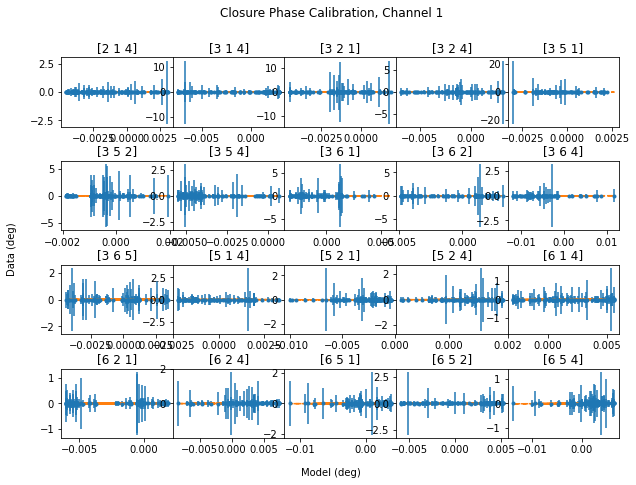

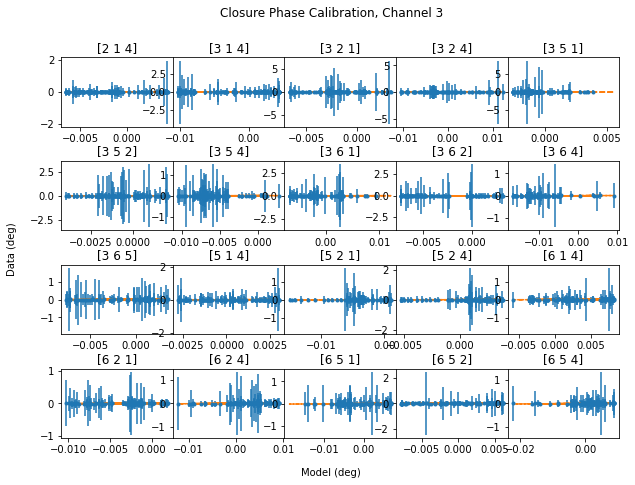

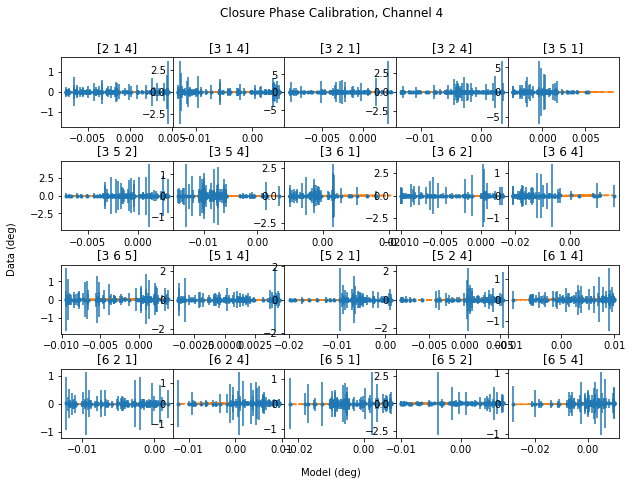

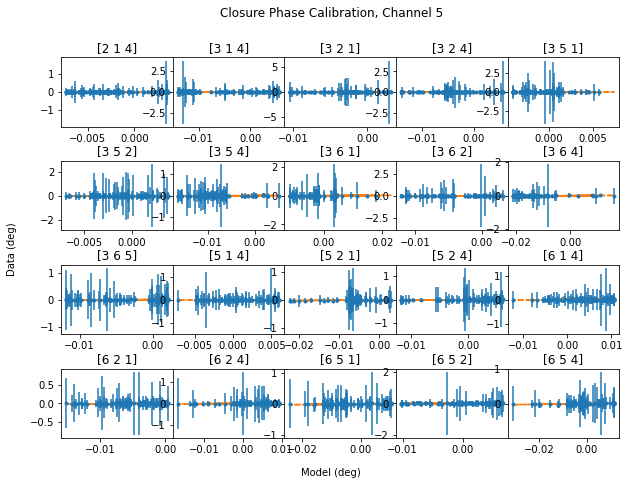

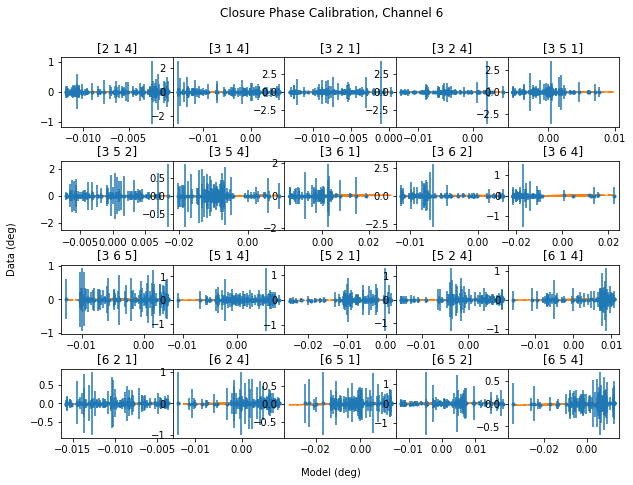

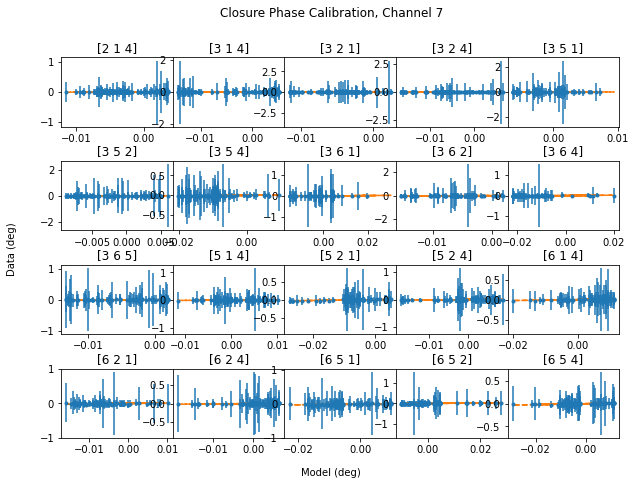

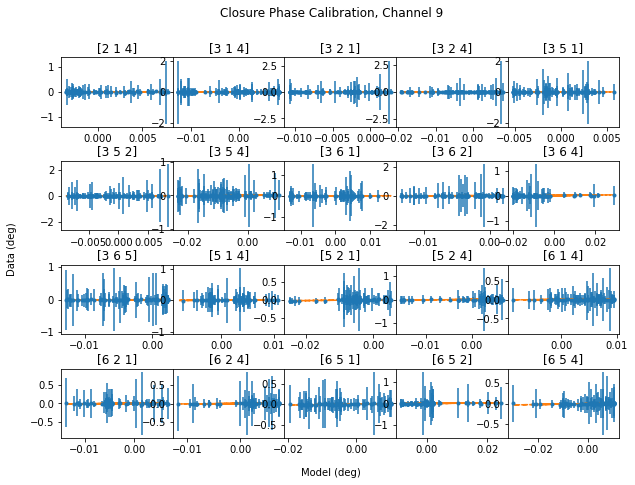

In [114]:
## Plot to see MODEL VS DATA comparisons

label_size = 10
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
index = np.arange(len(unique_tels))

for channel in np.arange(bl.shape[-1]): 
#for channel in [100,500,1000,1500]: 
    
    fig,axs = plt.subplots(4,5,figsize=(10,7),facecolor='w',edgecolor='k')
    index = np.arange(len(unique_tels))
        
    fig.subplots_adjust(hspace=0.5,wspace=.001)
    axs=axs.ravel()
    
    ax_idx = 0
    for bl,blerr,azim,al,pa,label,a0,a1,a2,a3,a4,a5 in zip(cp,cperr,azimuth,altitude,parallactic,tri,a0mod,a1mod,a2mod,a3mod,a4mod,a5mod):
    #for bl,blerr,pa,label,a0,a1,a2 in zip(cp,cperr,parallactic,tri,a0mod,a1mod,a2mod):
    #for bl,blerr,hour,label,a0,a1 in zip(cp,cperr,ha,tri,a0mod,a1mod):
        
        t3data=np.array(bl[:,channel])
        t3errdata=np.array(blerr[:,channel])
        
        x_az=np.array(azim)
        x_alt=np.array(al)
        x_az = ((x_az*np.pi/180 + np.pi) % (2 * np.pi) - np.pi )*180/np.pi
        x_alt = ((x_alt*np.pi/180 + np.pi) % (2 * np.pi) - np.pi )*180/np.pi
        x1data = x_az
        x2data = x_alt
        
        model = a0[channel] + a1[channel]*x1data + a2[channel]*x1data**2 + a3[channel]*x1data*x2data + a4[channel]*x2data + a5[channel]*x2data**2
        #model = a0[channel] + a1[channel]*pa + a2[channel]*pa**2 #+ a3[channel]*x1data*x2data + a4[channel]*x2data + a5[channel]*x2data**2
        #model = a0[channel] + a1[channel]*hour

        axs[int(ax_idx)].errorbar(model,t3data,yerr=t3errdata,fmt='.')
        axs[int(ax_idx)].set_title(str(label))
        axs[int(ax_idx)].plot(model,model,'--')
        
        ax_idx+=1
        
    fig.suptitle('Closure Phase Calibration, Channel %s'%channel)
    fig.text(0.5, 0.05, 'Model (deg)', ha='center')
    fig.text(0.05, 0.5, 'Data (deg)', va='center', rotation='vertical')
    plt.savefig('%s/%s_calibration_%s.pdf'%(tar_dir,date,channel))
    plt.show()

In [115]:
## apply correction based on cals

t3phi_old = t3phi.copy()
n_data = np.arange(t3phi.shape[0])
n_channels = np.arange(t3phi.shape[1])

## apply correction based on cals -- Ming model
for i in n_data:
    for tri,a0,a1,a2,a3,a4,a5 in zip(telmod,a0mod,a1mod,a2mod,a3mod,a4mod,a5mod):
    #for tri,a0,a1,a2 in zip(telmod,a0mod,a1mod,a2mod):
    #for tri,a0,a1 in zip(telmod,a0mod,a1mod):
        if str(tri)==str(tels[i]):
            
            #if 'E1' in str(tri) and 'W2' in str(tri) and 'W1' in str(tri):
            #    print('Skipping E1-W2-W1')
            #    continue
                        
            for j in n_channels:
                x_az = az[i]
                x_alt = alt[i]
                x_az = ((x_az*np.pi/180 + np.pi) % (2 * np.pi) - np.pi )*180/np.pi
                x_alt = ((x_alt*np.pi/180 + np.pi) % (2 * np.pi) - np.pi )*180/np.pi
                x1 = x_az
                x2 = x_alt
                t3model = a0[j] + a1[j]*x1 + a2[j]*x1**2 + a3[j]*x1*x2 + a4[j]*x2 + a5[j]*x2**2
                #t3model = a0[j] + a1[j]*par_angle[i] + a2[j]*par_angle[i]**2
                #t3model = a0[j] + a1[j]*hour_angle[i]
                #print(t3model)
                
                t3phi[i][j] -= t3model

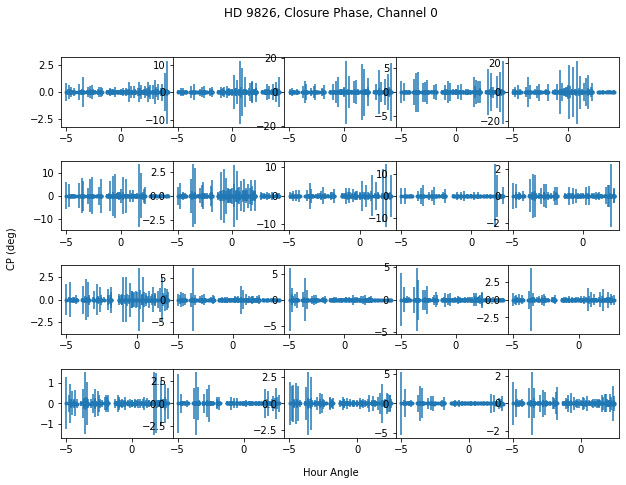

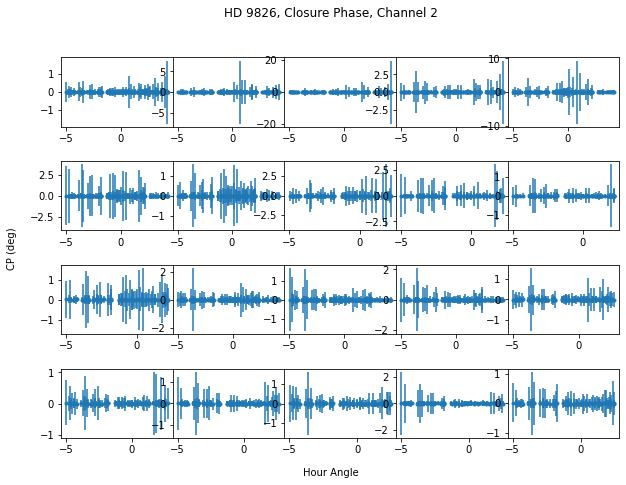

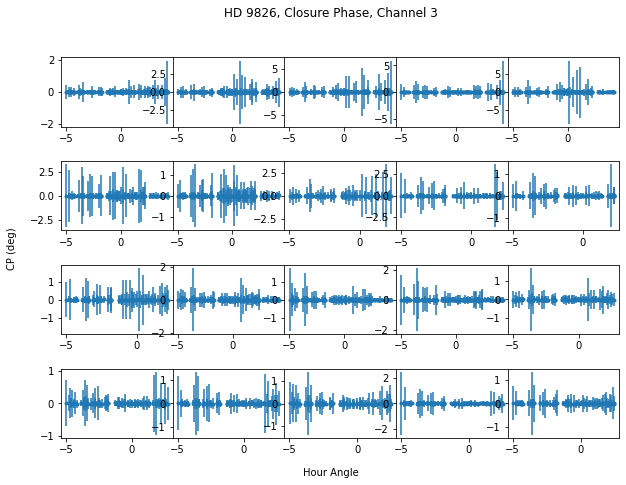

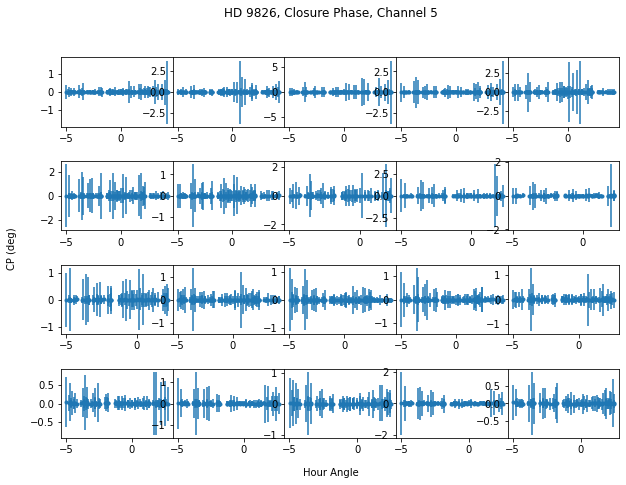

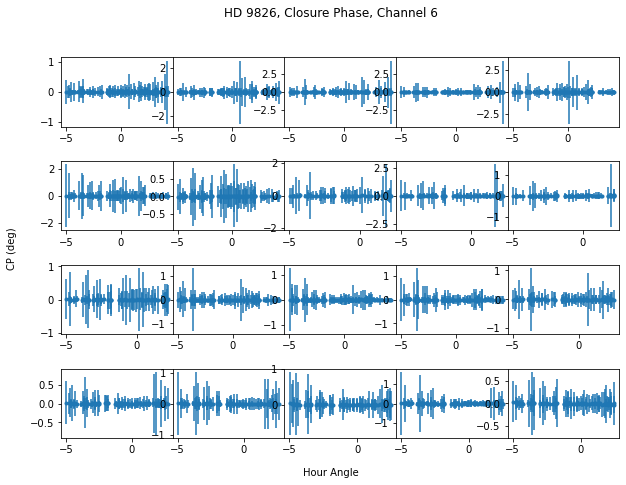

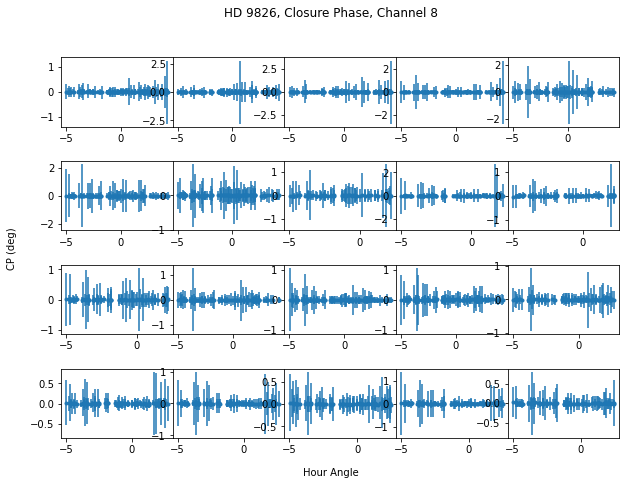

In [116]:
 ###################
#### Plot vs HA
###################

channel = np.arange(t3phi.shape[-1])
#channel = [100,500,1000,1500]

label_size = 10
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size

for chan in channel:
    
    fig,axs = plt.subplots(4,5,figsize=(10,7),facecolor='w',edgecolor='k')
    index = np.arange(len(unique_tels))
        
    fig.subplots_adjust(hspace=0.5,wspace=.001)
    axs=axs.ravel()
        
    for ind in index:
        
        ## TAR
        t3data=[]
        t3errdata=[]
        hdata=[]
        for t,terr,tri,tt in zip(t3phi,t3phierr,tels,hour_angle):
            if str(tri)==str(unique_tels[int(ind)]):
                t3data.append(t)
                t3errdata.append(terr)
                hdata.append(tt)
        t3data=np.array(t3data)
        t3errdata=np.array(t3errdata)
        hdata=np.array(hdata)

        x=hdata
        y=t3data[:,chan]
        yerr=t3errdata[:,chan]
        axs[int(ind)].errorbar(x,y,yerr=yerr,fmt='.')
        #axs[int(ind)].set_ylim(-3,3)

    fig.suptitle('HD 9826, Closure Phase, Channel %s'%chan)
    fig.text(0.5, 0.05, 'Hour Angle', ha='center')
    fig.text(0.05, 0.5, 'CP (deg)', va='center', rotation='vertical')
    plt.savefig('%s/%s_ha_t3phi_final_%s.pdf'%(tar_dir,date,chan))
    plt.show()

In [121]:
## filter once more
nloop = 0
n_stdev = 5
while nloop<3:
    t3phi_filtered = medfilt(t3phi,(1,5))
    t3phi_resid = t3phi-t3phi_filtered
    std_t3phi = np.nanstd(t3phi_resid)
    idx_t3phi = np.where(abs(t3phi_resid)>(n_stdev*std_t3phi))
    t3phi[idx_t3phi]=np.nan
    nloop+=1
print('Standard deviation t3phi TAR = ',std_t3phi)

Standard deviation t3phi TAR =  0.001049227135861328


In [122]:
plt.plot(t3phi_old,'.',color='lightgrey')
plt.plot(t3phi,'.',color='black')
plt.ylabel('T3PHI (deg)')
plt.xlabel('Triangle #')
plt.show()

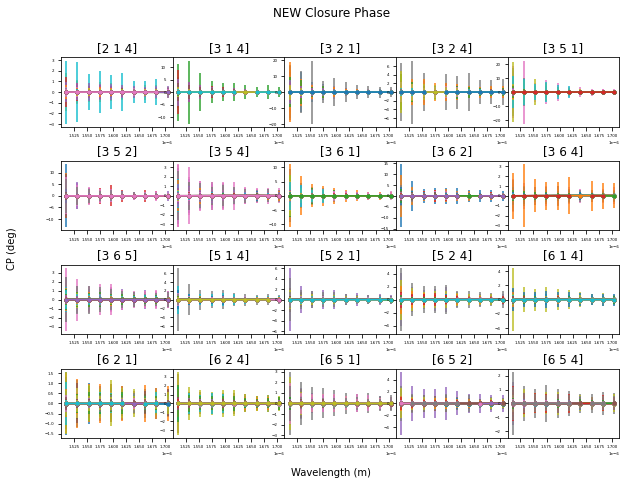

In [123]:
## plot NEW t3phi data
label_size = 4
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size

fig,axs = plt.subplots(4,5,figsize=(10,7),facecolor='w',edgecolor='k')
index = np.arange(len(unique_tels))

fig.subplots_adjust(hspace=0.5,wspace=.001)
axs=axs.ravel()

for ind in index:
    t3data=[]
    t3errdata=[]
    for t,terr,tri in zip(t3phi,t3phierr,tels):
        if str(tri)==str(unique_tels[int(ind)]):
            t3data.append(t)
            t3errdata.append(terr)
    t3data=np.array(t3data)
    t3errdata=np.array(t3errdata)

    for y,yerr in zip(t3data,t3errdata):
        x=eff_wave[0]
        axs[int(ind)].errorbar(x,y,yerr=yerr,fmt='.-')
    axs[int(ind)].set_title(str(unique_tels[int(ind)]))

fig.suptitle('NEW Closure Phase')
fig.text(0.5, 0.05, 'Wavelength (m)', ha='center')
fig.text(0.05, 0.5, 'CP (deg)', va='center', rotation='vertical')
plt.savefig('%s/%s_t3phi_NEW.pdf'%(tar_dir,date))
#plt.show()

In [124]:
print('uncorrected mean and std:')
print(np.nanmean(t3phi_old[1:-1]))
print(np.nanstd(t3phi_old[1:-1]))
print('---------------------')
print('corrected mean and std:')
print(np.nanmean(t3phi[1:-1]))
print(np.nanstd(t3phi[1:-1]))
print('---------------------')

uncorrected mean and std:
-0.0013576559495291386
0.009559789843494886
---------------------
corrected mean and std:
0.0007870722327736527
0.008557851831648113
---------------------


In [125]:
## save array
np.save('%s/%s_t3phi_NEW.npy'%(tar_dir,date),t3phi)

In [126]:
## save array
np.save('%s/%s_t3phi_RAW.npy'%(tar_dir,date),t3phi_old)

In [127]:
## save fit values
np.save('%s/%s_a0mod.npy'%(tar_dir,date),a0mod)
np.save('%s/%s_a1mod.npy'%(tar_dir,date),a1mod)
np.save('%s/%s_a2mod.npy'%(tar_dir,date),a2mod)
np.save('%s/%s_a3mod.npy'%(tar_dir,date),a3mod)
np.save('%s/%s_a4mod.npy'%(tar_dir,date),a4mod)
np.save('%s/%s_a5mod.npy'%(tar_dir,date),a5mod)
np.save('%s/%s_telmod.npy'%(tar_dir,date),telmod)

## Now Save new OIFITS files with calibration applied

In [129]:
## Load files
print('--'*10)
print('--'*10)
nstart=0
for file in sorted(os.listdir(tar_dir)):
    if file.endswith('.oifits'):
        
        filename = os.path.join(tar_dir, file)
        print(file[:-7])
        
        hdu = fits.open(filename)
        
        print("Shape of original data = ", hdu['OI_T3'].data['T3PHI'].shape)
        nmeasures = hdu['OI_T3'].data['T3PHI'].shape[0]
        nend = nstart+nmeasures
        print("Shape of new data = ", t3phi[nstart:nend,:].shape)
        
        print("Writing new fits files")
        ## calibrated, cleaned
        hdu['OI_T3'].data['T3PHI'] = t3phi[nstart:nend,:]
        hdu.writeto('%s/new_files/%s_CALIBRATED.oifits'%(tar_dir,file[:-7]),overwrite=True)
        
        ## raw, cleaned
        hdu['OI_T3'].data['T3PHI'] = t3phi_old[nstart:nend,:]
        hdu.writeto('%s/new_files/%s_RAW.oifits'%(tar_dir,file[:-7]),overwrite=True)
        
        nstart+=nmeasures
        hdu.close()
        
        print('--'*10)
        print('--'*10)

--------------------
--------------------
FANCY_SIMULATION.UpsAnd.FACTOR_001.000.Omega51.inc156.MIRCX_L2.2023Oct03.ups_And.MIRCX_IDL.TG_Cal.AVG15m.MEDFILT
Shape of original data =  (94, 10)
Shape of new data =  (94, 10)
Writing new fits files
--------------------
--------------------
FANCY_SIMULATION.UpsAnd.FACTOR_001.000.Omega51.inc156.MIRCX_L2.2023Oct04.ups_And.MIRCX_IDL.TG_Cal.AVG15m.MEDFILT
Shape of original data =  (420, 10)
Shape of new data =  (420, 10)
Writing new fits files
--------------------
--------------------
FANCY_SIMULATION.UpsAnd.FACTOR_001.000.Omega51.inc156.MIRCX_L2.2023Oct05.ups_And.MIRCX_IDL.TG_Cal.AVG15m.MEDFILT
Shape of original data =  (428, 10)
Shape of new data =  (428, 10)
Writing new fits files
--------------------
--------------------
FANCY_SIMULATION.UpsAnd.FACTOR_001.000.Omega51.inc156.MIRCX_L2.2023Oct06.ups_And.MIRCX_IDL.TG_Cal.AVG15m.MEDFILT
Shape of original data =  (515, 10)
Shape of new data =  (515, 10)
Writing new fits files
--------------------
-

In [130]:
## Make sure there was no saving error
## Use calibrators to measure drift with alt/az

t3phi_new = []
t3phierr_new = []

t3phi_raw_new = []
t3phierr_raw_new = []

for file in sorted(os.listdir('%s/new_files/'%tar_dir)):
    if file.endswith('CALIBRATED.oifits'):
    
        filename = os.path.join('%s/new_files/'%tar_dir, file)
        print(filename)
        hdu = fits.open(filename)
    
        for table in hdu:
            ## t3phi data:
            wl_i=1
            if table.name=='OI_T3':
                for i in eachindex(table.data):
                    t3 = table.data[i]['T3PHI']
                    t3err = table.data[i]['T3PHIERR']
                    t3flag = np.where(table.data[i].field('FLAG')==True)
                    t3[t3flag] = np.nan
                    t3err[t3flag] = np.nan
                    t3phi_new.append(t3)
                    t3phierr_new.append(t3err)
                wl_i+=1
        hdu.close()
    

print('--'*10)
print('--'*10)

for file in sorted(os.listdir('%s/new_files/'%tar_dir)):
    if file.endswith('RAW.oifits'):
    
        filename = os.path.join('%s/new_files/'%tar_dir, file)
        print(filename)
        hdu = fits.open(filename)
    
        for table in hdu:
            ## t3phi data:
            wl_i=1
            if table.name=='OI_T3':
                for i in eachindex(table.data):
                    t3 = table.data[i]['T3PHI']
                    t3err = table.data[i]['T3PHIERR']
                    t3flag = np.where(table.data[i].field('FLAG')==True)
                    t3[t3flag] = np.nan
                    t3err[t3flag] = np.nan
                    t3phi_raw_new.append(t3)
                    t3phierr_raw_new.append(t3err)
                wl_i+=1
        hdu.close()
        
t3phi_new = np.array(t3phi_new)
t3phierr_new = np.array(t3phierr_new)

t3phi_raw_new = np.array(t3phi_raw_new)
t3phierr_raw_new = np.array(t3phierr_raw_new)

/Users/tgardner/data/2023Oct_UpsAnd_FANCY_SIMULATIONS/MIRCX/2023Oct/factor_001.000/medfilt//new_files/FANCY_SIMULATION.UpsAnd.FACTOR_001.000.Omega51.inc156.MIRCX_L2.2023Oct03.ups_And.MIRCX_IDL.TG_Cal.AVG15m.MEDFILT_CALIBRATED.oifits
/Users/tgardner/data/2023Oct_UpsAnd_FANCY_SIMULATIONS/MIRCX/2023Oct/factor_001.000/medfilt//new_files/FANCY_SIMULATION.UpsAnd.FACTOR_001.000.Omega51.inc156.MIRCX_L2.2023Oct04.ups_And.MIRCX_IDL.TG_Cal.AVG15m.MEDFILT_CALIBRATED.oifits
/Users/tgardner/data/2023Oct_UpsAnd_FANCY_SIMULATIONS/MIRCX/2023Oct/factor_001.000/medfilt//new_files/FANCY_SIMULATION.UpsAnd.FACTOR_001.000.Omega51.inc156.MIRCX_L2.2023Oct05.ups_And.MIRCX_IDL.TG_Cal.AVG15m.MEDFILT_CALIBRATED.oifits
/Users/tgardner/data/2023Oct_UpsAnd_FANCY_SIMULATIONS/MIRCX/2023Oct/factor_001.000/medfilt//new_files/FANCY_SIMULATION.UpsAnd.FACTOR_001.000.Omega51.inc156.MIRCX_L2.2023Oct06.ups_And.MIRCX_IDL.TG_Cal.AVG15m.MEDFILT_CALIBRATED.oifits
/Users/tgardner/data/2023Oct_UpsAnd_FANCY_SIMULATIONS/MIRCX/2023Oct/

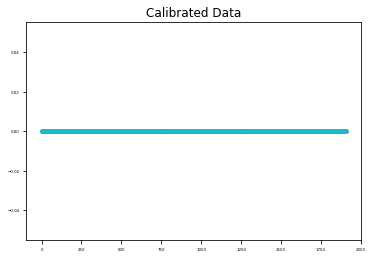

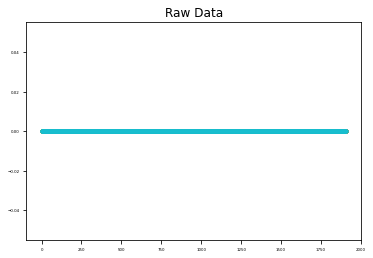

In [131]:
plt.plot(t3phi_new - t3phi,'.')
plt.title('Calibrated Data')
plt.show()

plt.plot(t3phi_raw_new - t3phi_old, '.')
plt.title('Raw Data')
plt.show()

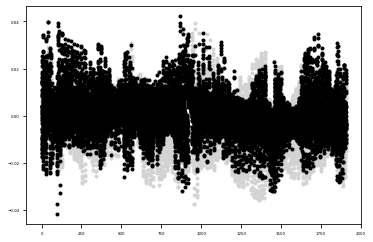

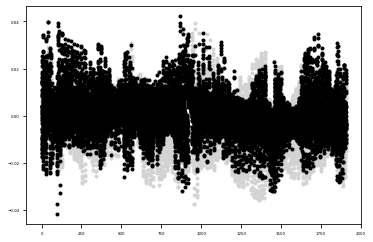

In [132]:
plt.plot(t3phi_old,'.',color='lightgrey')
plt.plot(t3phi,'.',color='black')
plt.show()

plt.plot(t3phi_raw_new,'.',color='lightgrey')
plt.plot(t3phi_new,'.',color='black')
plt.show()